In [1]:
%load_ext lab_black

In [101]:
from pathlib import Path
from typing import Union, Dict, Optional, List, Tuple
from collections import defaultdict
import warnings
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.cluster as spc
from tqdm import tqdm
import xarray as xr

from camelsml.metrics import calc_nse
from camelsml.datautils import load_attributes, load_discharge
from camelsml import load_config
from camelsml.utils import get_basin_list

In [3]:
plt.style.use("../figstyle.mplstyle")

# This notebook contains results from our attempt at reducing static features.

In [4]:
def correlation(
    attributes: pd.DataFrame, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    corr = attributes.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.7747, 4.7747))
    ax.tick_params(axis="both", which="both", labelsize=5)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.1,
        cbar_kws={"shrink": 0.5},
        ax=ax,
    )
    ax.xaxis.label.set_size(5)
    ax.yaxis.label.set_size(0)
    if title is not None:
        ax.set_title(title)

In [5]:
def dendrogram(
    attributes: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
) -> np.ndarray:
    # Using the absolute value Pearson correlations.
    corr = attributes.corr().abs()
    corr_linkage = spc.hierarchy.ward(corr)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    dendro = spc.hierarchy.dendrogram(
        corr_linkage, ax=ax, orientation="left", labels=attributes.columns
    )
    return corr_linkage


def feature_reduction(
    corr_linkage: np.ndarray, level: int, labels: np.ndarray
) -> np.ndarray:
    cluster_ids = spc.hierarchy.fcluster(corr_linkage, level, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return labels[selected_features]

In [5]:
# This cell is messed up now
"""cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")
db_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"
basins = get_basin_list(cfg["train_basin_file"])
attributes = load_attributes(
    db_path=db_path,
    basins=basins,
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))
axes = axes.flatten()
correlation(attributes, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
corr_linkage = dendrogram(attributes, ax=axes[0])
# axes[0].set_yticks([])
# axes[0].set_xticks([])
fig.tight_layout()
fig.savefig(
    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"
)"""

'cfg = load_config("../runs/correlation_reduction/all_features/run_config.txt")\ndb_path = "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204/attributes.db"\nbasins = get_basin_list(cfg["train_basin_file"])\nattributes = load_attributes(\n    db_path=db_path,\n    basins=basins,\n)\nfig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))  # 8.27615))\naxes = axes.flatten()\ncorrelation(attributes, ax=axes[1])\naxes[1].set_xticks([])\naxes[1].set_yticks([])\ncorr_linkage = dendrogram(attributes, ax=axes[0])\n# axes[0].set_yticks([])\n# axes[0].set_xticks([])\nfig.tight_layout()\nfig.savefig(\n    "../doc/thesis/figures/correlation_reduction/all_features/corr_and_dendrogram.pdf"\n)'

In [6]:
def load_results(
    folder: Union[Path, str], model_type: str, seed: int, debug: bool = False
) -> Union[Dict, Tuple[Dict, Dict]]:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    if debug:
        results_debug = {}
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        if debug:
            results_debug[epoch] = results.copy()
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    if debug:
        return nse_values, results_debug
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str],
    k,
    model_type: str,
    seed: int,
    epoch: int = 30,
    debug: bool = False,
) -> Union[Dict, Tuple[Dict, Dict]]:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    if debug:
        results_debug = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        if debug:
            results[i], results_debug[i] = load_results(
                folder, model_type, seed, debug=True
            )
        else:
            results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    if debug:
        return full_results, results_debug
    return full_results

In [7]:
def restructure_results(nse_values: Dict) -> np.ndarray:
    results = []
    for i, epoch in enumerate(nse_values.keys()):
        results.append(np.array(list(nse_values[epoch].values())))
    results = np.array(results).T
    return results


def nse_boxplots(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.boxplot(nse_values, showmeans=True)
    ax.set_ylabel("NSE")
    ax.grid()
    epochs = nse_values.shape[1] + 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    if title is not None:
        ax.set_title(title)


def plot_median_average(
    nse_values: np.ndarray, title: Optional[str] = None, ax: Optional[plt.Axes] = None
) -> Tuple[plt.Line2D, plt.Line2D]:
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    line_mean = ax.plot(epochs, nse_values.mean(axis=0), label="mean")[0]
    line_median = ax.plot(epochs, np.median(nse_values, axis=0), label="median")[0]
    # ax.set_ylim([0, 1])
    # ax.set_xlabel("Epoch")
    # ax.set_ylabel("NSE")
    ax.grid()
    # ax.legend()
    if title is not None:
        ax.set_title(title)
    return line_mean, line_median


def plot_fractions(
    nse_values: np.ndarray,
    good_model: float = 0.7,
    title: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    epochs = range(1, nse_values.shape[1] + 1)
    basins = nse_values.shape[0]
    frac = []
    for i, epoch in enumerate(nse_values.T):
        frac.append(len(epoch[epoch > good_model]))
        frac[i] /= basins
    ax.plot(epochs, frac)
    ax.set_xlabel("Epoch")
    # ax.set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
    ax.grid()
    if title is not None:
        ax.set_title(title)

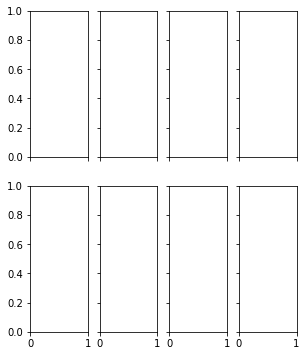

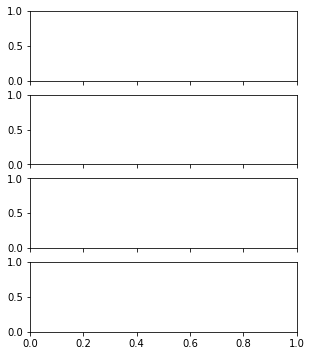

In [8]:
fig_runs_plots, axes_runs_plots = plt.subplots(
    2, 4, figsize=[4.7747, (4.7747 / 1.618) * 2], sharey=True, sharex=True
)
fig_runs_boxplots, axes_runs_boxplots = plt.subplots(
    4, 1, figsize=[4.7747, (4.7747 / 1.618) * 2], sharex=True, sharey=True
)

In [9]:
good_model = 0.7
results_full_features = load_results(
    "../runs/correlation_reduction/all_features/run_1412_0900_seed19970204",
    "ealstm",
    19970204,
)
nse_values_full = restructure_results(results_full_features)
title_full = "76 features"
nse_boxplots(
    nse_values_full,
    ax=axes_runs_boxplots[0],
    title=title_full,
)
plot_median_average(nse_values_full, ax=axes_runs_plots[0, 0], title=title_full)
plot_fractions(nse_values_full, good_model=good_model, ax=axes_runs_plots[1, 0])

UnboundLocalError: local variable 'results_debug' referenced before assignment

## Removing 20 features by setting the treshold to 9.3

This will be used to train a new model

In [ ]:
keep = feature_reduction(corr_linkage, level=0.93, labels=attributes.columns.to_numpy())
np.savetxt(
    "../runs/correlation_reduction/20_less_features/use_features.txt", keep, fmt="%s"
)
fig_corr_56, axes_corr_56 = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes_corr_56.flatten()
reduced_attributes_20 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_20, ax=axes_corr_56[0])
corr_linkage_20_less = dendrogram(reduced_attributes_20, ax=axes_corr_56[1])
fig_corr_56.tight_layout()

In [ ]:
results_56_features = load_results(
    "../runs/correlation_reduction/20_less_features/run_1512_0054_seed19970204",
    "ealstm",
    19970204,
)
title_56_features = "56 features"
nse_values_56_features = restructure_results(results_56_features)
nse_boxplots(nse_values_56_features, ax=axes_runs_boxplots[1], title=title_56_features)
plot_median_average(
    nse_values_56_features, title=title_56_features, ax=axes_runs_plots[0, 1]
)
plot_fractions(nse_values_56_features, ax=axes_runs_plots[1, 1])

In [ ]:
keep = feature_reduction(
    corr_linkage_20_less, level=1.15, labels=reduced_attributes_20.columns.to_numpy()
)
np.savetxt(
    "../runs/correlation_reduction/40_less_features/use_features.txt", keep, fmt="%s"
)
fig, axes = plt.subplots(2, 1, figsize=(4.7747, 4.47747 * 1.618))
axes = axes.flatten()
reduced_attributes_40 = load_attributes(db_path, basins=basins, keep_features=keep)
correlation(reduced_attributes_40, ax=axes[0])
corr_linkage_40_less = dendrogram(reduced_attributes_40, ax=axes[1])
fig.tight_layout()
print(reduced_attributes_40.shape)

In [ ]:
results_36_features = load_results(
    "../runs/correlation_reduction/40_less_features/run_1512_1507_seed19970204",
    "ealstm",
    19970204,
)
title_36_features = "36 features"
nse_values_36_features = restructure_results(results_36_features)
nse_boxplots(nse_values_36_features, ax=axes_runs_boxplots[2], title=title_36_features)
plot_median_average(
    nse_values_36_features, title=title_36_features, ax=axes_runs_plots[0, 2]
)
plot_fractions(nse_values_36_features, ax=axes_runs_plots[1, 2])

## No features

In [8]:
results_no_features = load_results(
    "../runs/correlation_reduction/no_features/run_1612_0909_seed19970204",
    "lstm_no_static",
    19970204,
)
title_no_features = "no features"
nse_values_no_features = restructure_results(results_no_features)
nse_boxplots(nse_values_no_features, title=title_no_features, ax=axes_runs_boxplots[3])
line_mean, line_median = plot_median_average(
    nse_values_no_features, title=title_no_features, ax=axes_runs_plots[0, 3]
)
plot_fractions(nse_values_no_features, ax=axes_runs_plots[1, 3])

NameError: name 'axes_runs_boxplots' is not defined

In [ ]:
axes_runs_plots[0, 0].set_ylabel("NSE")
axes_runs_plots[1, 0].set_ylabel(rf"$\frac{{nse>{good_model}}}{{nse}}$")
axes_runs_plots[1, 1].set_xlabel("Epochs")
axes_runs_plots[0, 0].set_ylim([0, 1])
fig_runs_plots.legend(handles=[line_mean, line_median])
fig_runs_plots.tight_layout()
axes_runs_boxplots[0].set_ylim([0, 1])
axes_runs_boxplots[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axes_runs_boxplots[3].set_xlabel("Epochs")
fig_runs_boxplots.tight_layout()
fig_runs_boxplots.savefig("boxplots.pdf")
fig_runs_plots.savefig("plots.pdf")
fig_runs_plots

In [ ]:
fig_runs_boxplots

Forcing -> Physical model  (EXISTS FOR US)  -> Prediction 

                                                            -> Improved prediction 
                                                            
Forcing + static features -> Lstm model     -> Prediction 

In [ ]:
test = load_results(
    "../runs/correlation_reduction/chosen_features/run_2312_2011_seed19970204",
    "ealstm",
    19970204,
)
test_nse = restructure_results(test)
nse_boxplots(
    test_nse,
)
plt.ylim([0, 1])
plt.savefig("boxplot_manual_features.pdf")
plt.show()
plot_fractions(test_nse)
plt.ylabel("Fraction NSE > 0.7")
plt.savefig("fractions_manual_features.pdf")
plt.show()

In [9]:
results_chosen_features_gb_compare = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_gb_val_us",
    5,
    "ealstm",
    "19970204",
    epoch=30,
)
chosen_features_gb_compare_nse = restructure_results(results_chosen_features_gb_compare)


results_chosen_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv",
    5,
    "ealstm",
    "19970204",
    epoch=14,
)


chosen_cv_nse = restructure_results(results_chosen_cv)

results_chosen_and_position_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_with_position_cv",
    5,
    "ealstm",
    "19970204",
)

chosen_with_pos_cv_nse = restructure_results(results_chosen_and_position_cv)


results_chosen_concat_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_concat_cv",
    5,
    "lstm",
    "19970204",
)
chosen_concat_cv_nse = restructure_results(results_chosen_concat_cv)


results_no_features_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/no_features_cv",
    5,
    "lstm_no_static",
    "19970204",
)
no_features_cv_nse = restructure_results(results_no_features_cv)


results_all_features_fixed_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv",
    5,
    "ealstm",
    "19970204",
)
all_features_fixed_cv_nse = restructure_results(results_all_features_fixed_cv)

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


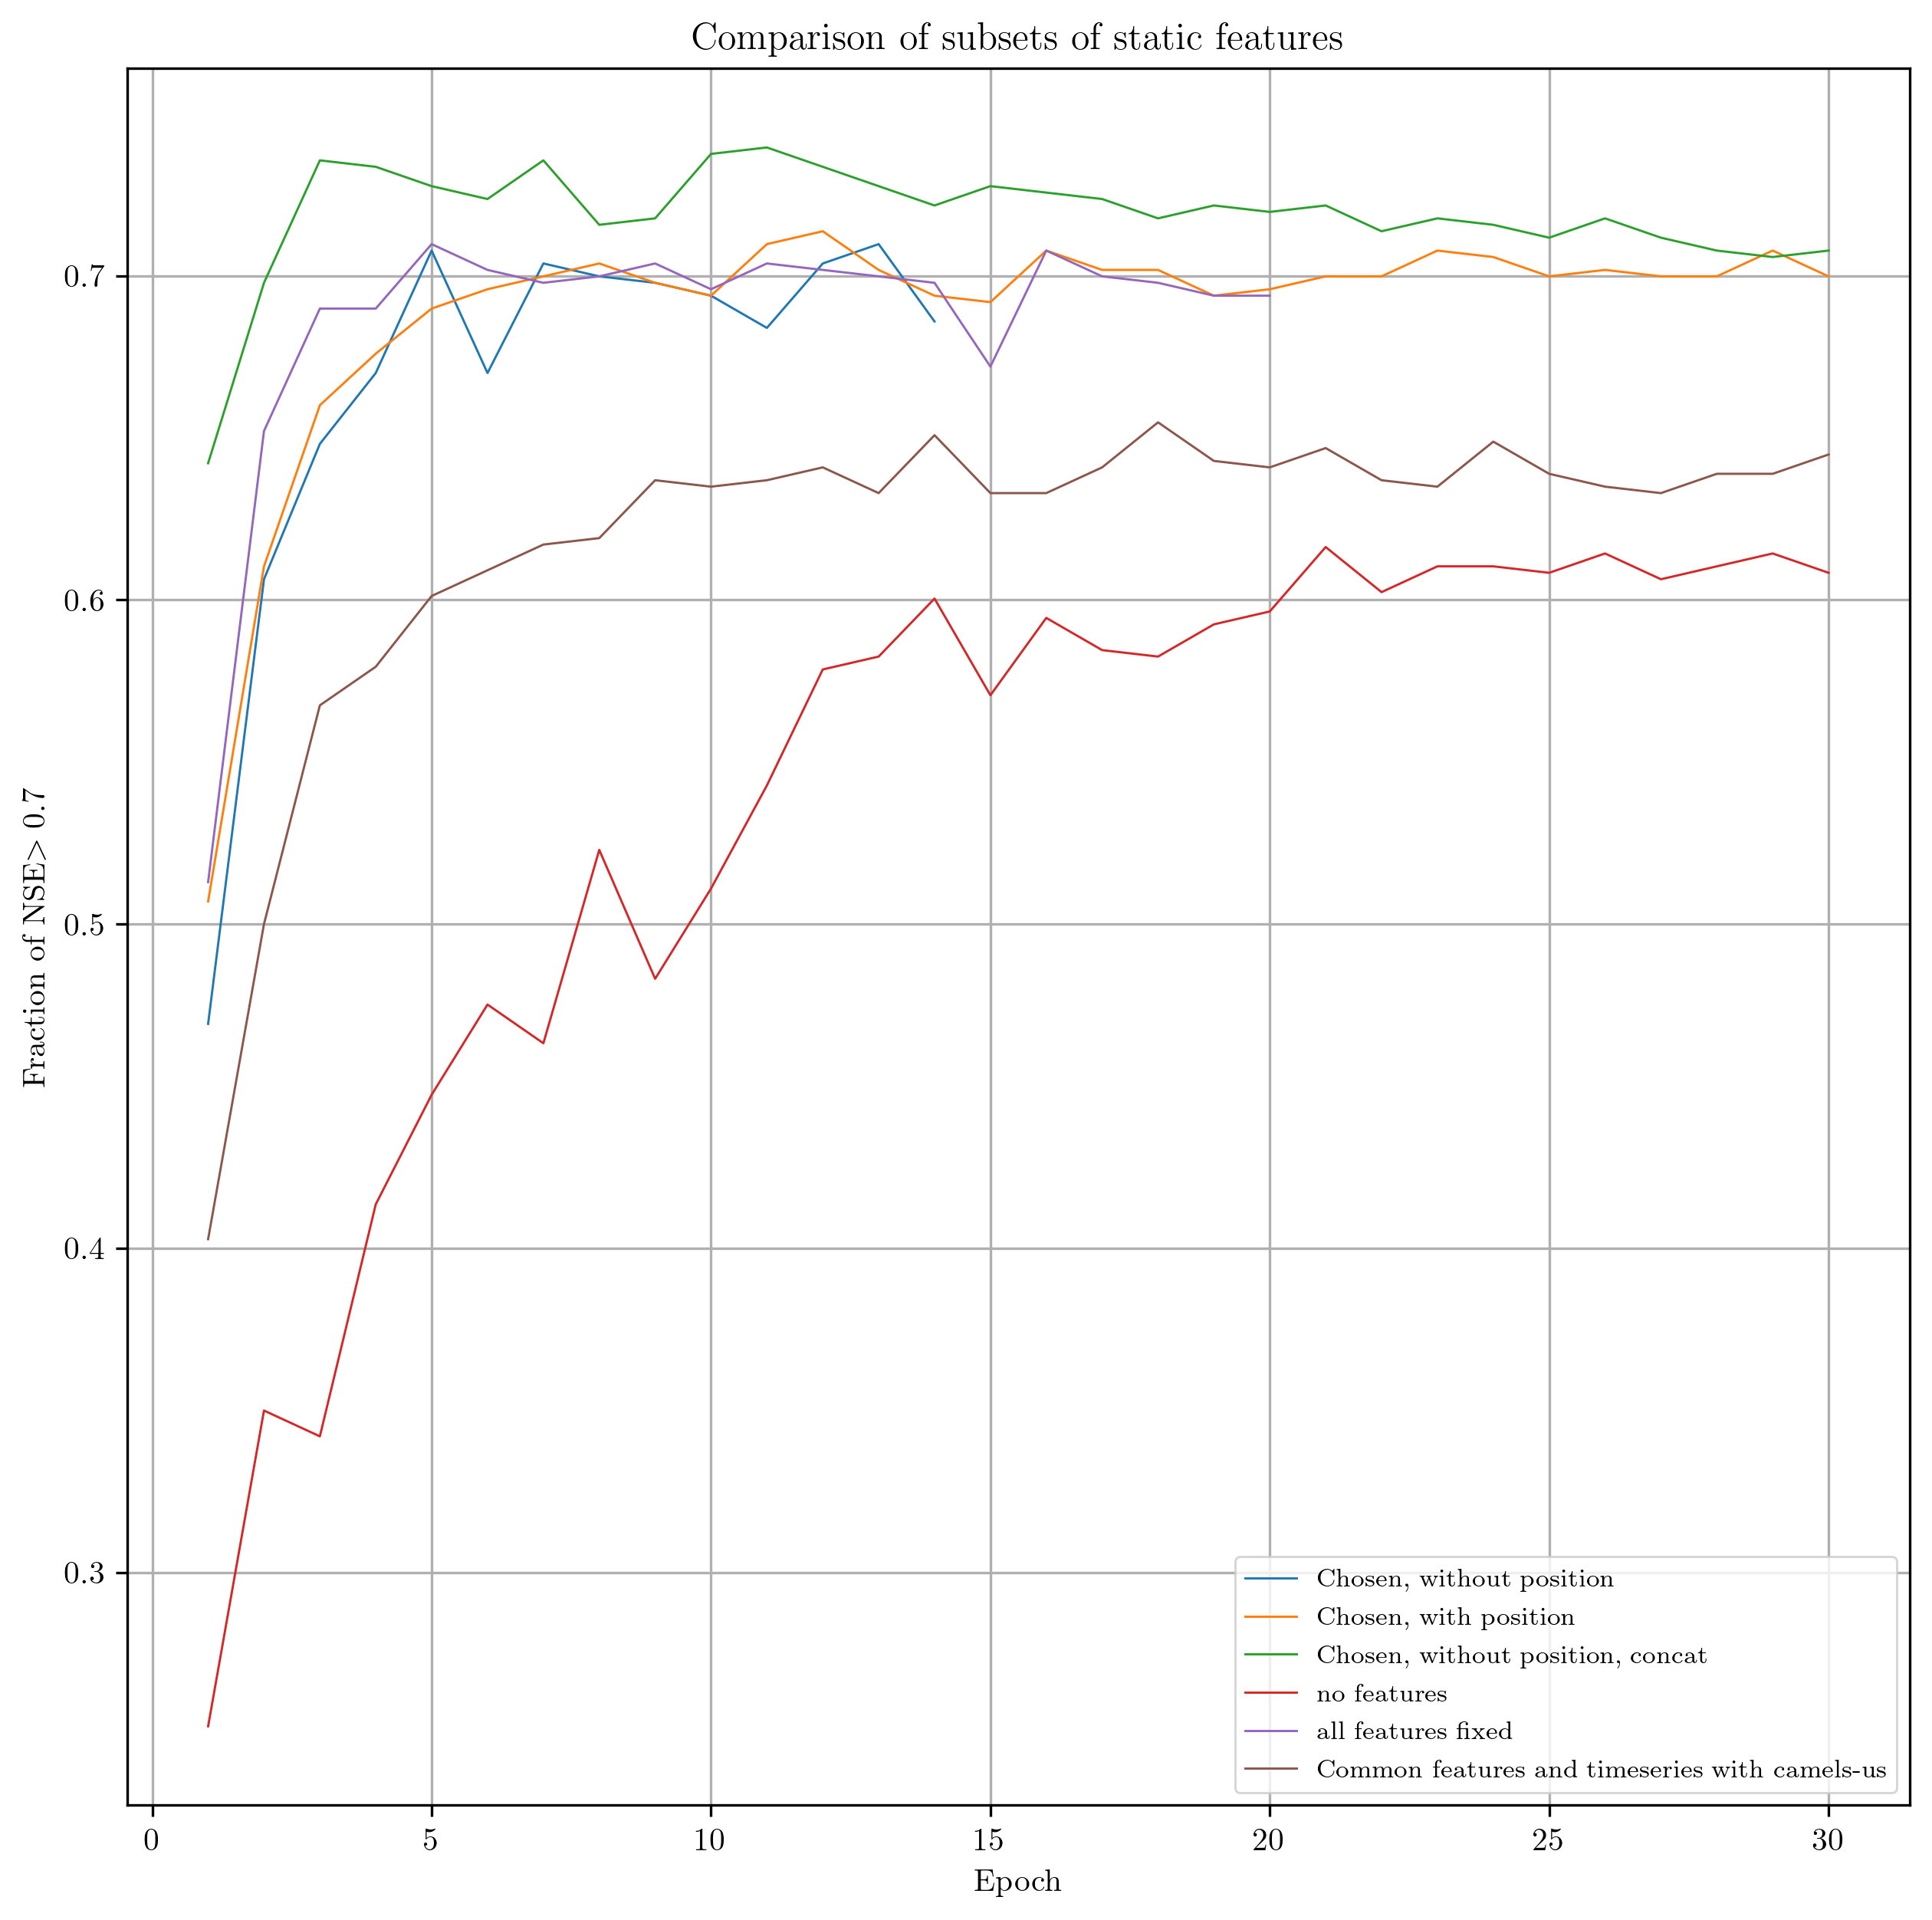

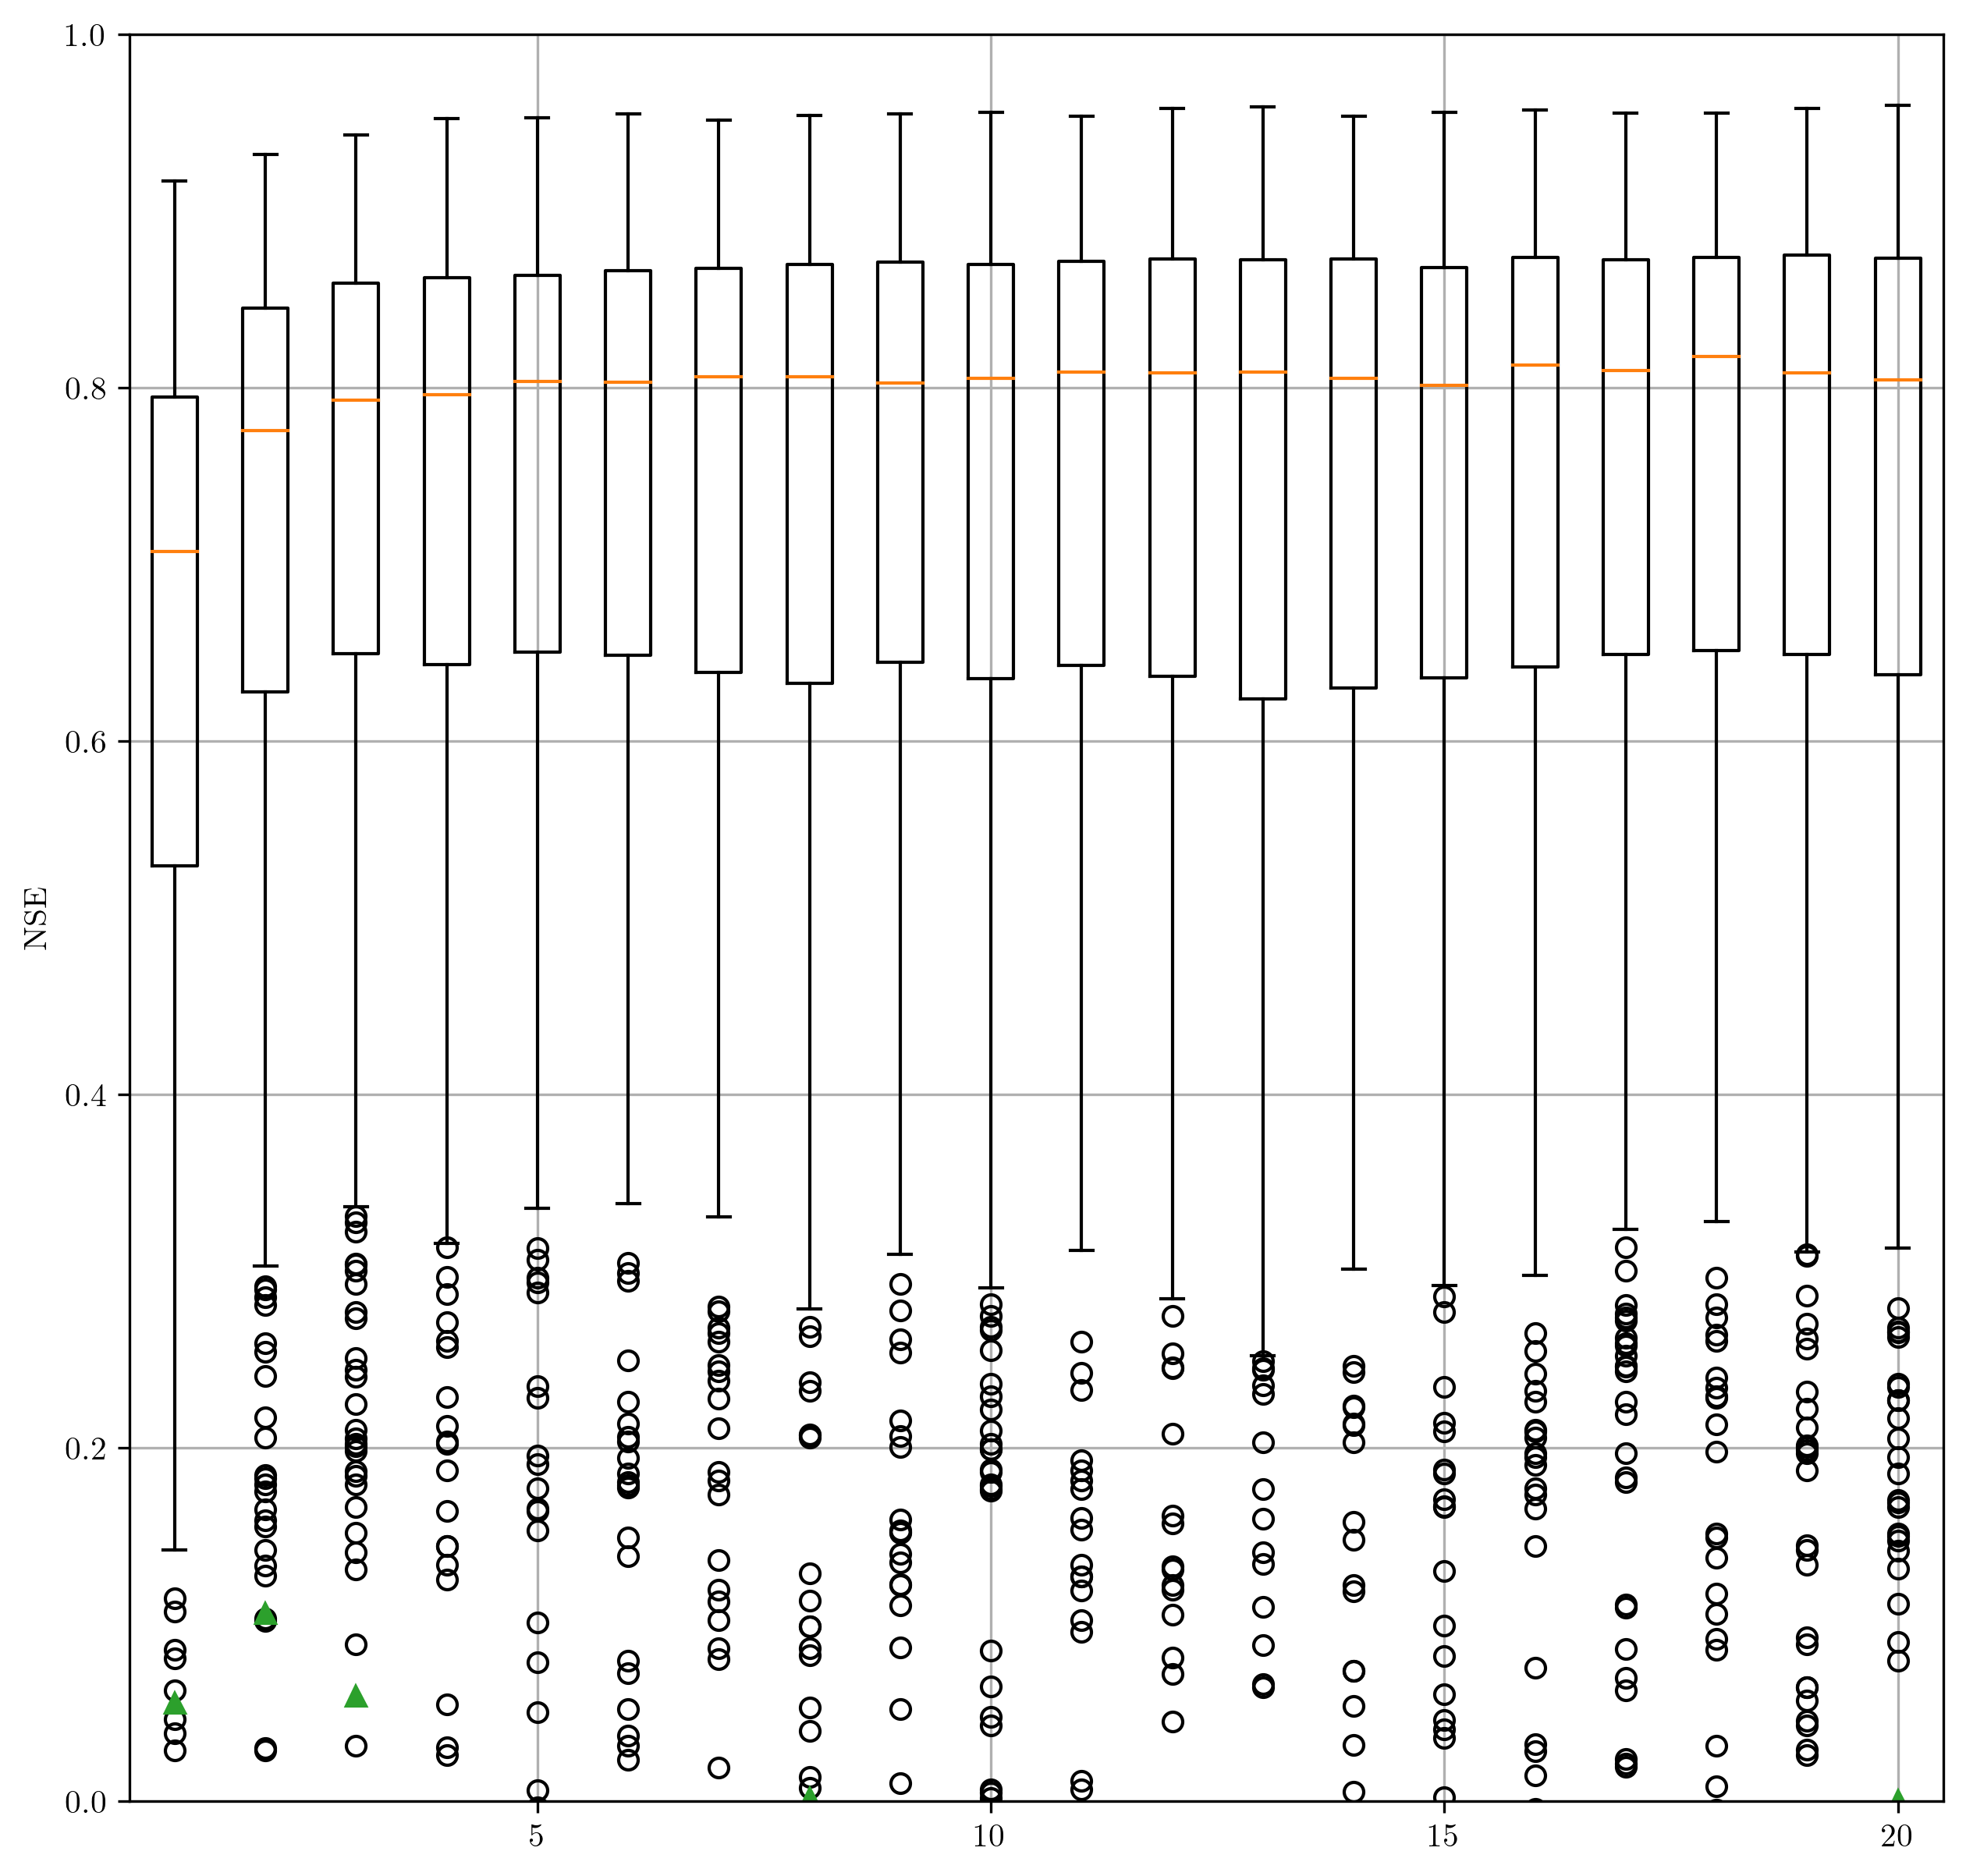

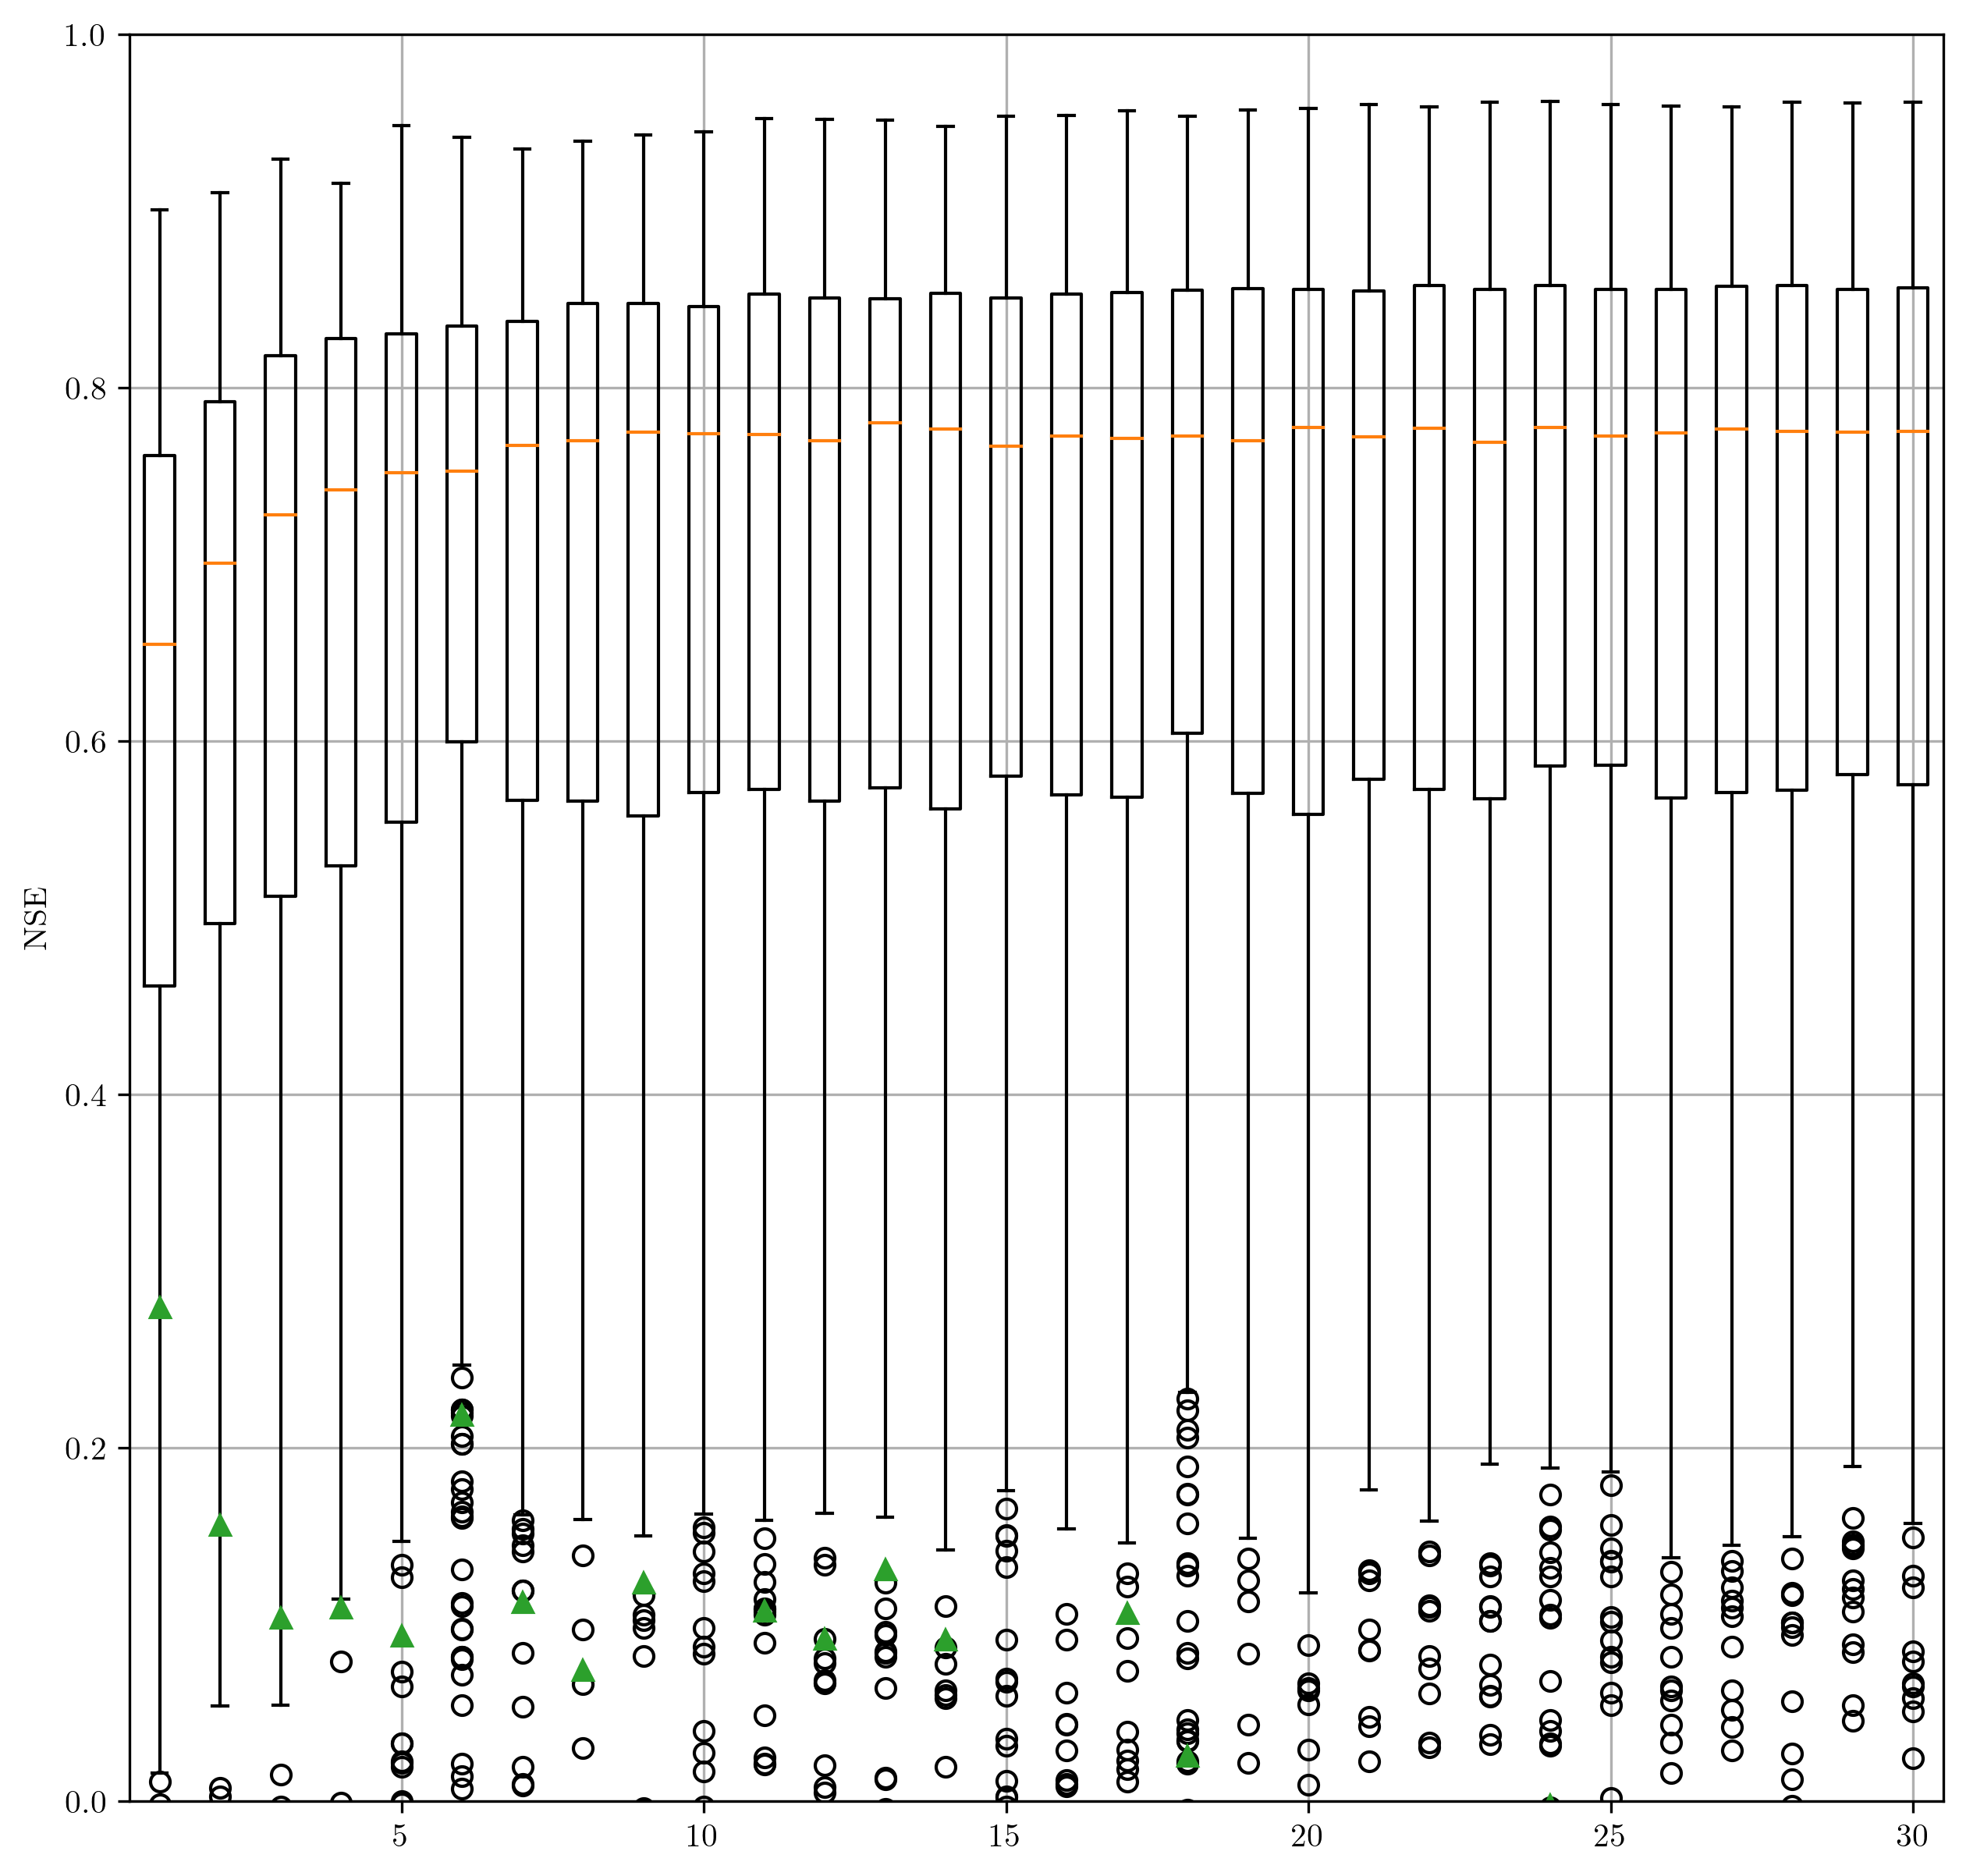

0.7754403984000249
0.8044036425691274


In [10]:
"""nse_boxplots(chosen_cv_nse)
plt.ylim([0, 1])
plt.show()"""

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_fractions(chosen_cv_nse, ax=ax)
plot_fractions(chosen_with_pos_cv_nse, ax=ax)
plot_fractions(chosen_concat_cv_nse, ax=ax)
plot_fractions(no_features_cv_nse, ax=ax)
plot_fractions(all_features_fixed_cv_nse, ax=ax)
plot_fractions(chosen_features_gb_compare_nse, ax=ax)
ax.legend(
    [
        "Chosen, without position",
        "Chosen, with position",
        "Chosen, without position, concat",
        "no features",
        "all features fixed",
        "Common features and timeseries with camels-us",
    ]
)
ax.set_title("Comparison of subsets of static features")
ax.set_ylabel("Fraction of NSE$>0.7$")
ax.grid()
plt.show()

nse_boxplots(all_features_fixed_cv_nse)
plt.ylim([0, 1])
plt.show()
"""
nse_boxplots(chosen_concat_cv_nse)
plt.ylim([0, 1])
plt.show()"""
nse_boxplots(chosen_features_gb_compare_nse)
plt.ylim([0, 1])
plt.show()
print(np.median(chosen_features_gb_compare_nse[:, 29]))
print(np.median(all_features_fixed_cv_nse[:, 19]))

In [ ]:
results_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv",
    5,
    "ealstm",
    "19970204",
)
cv_nse = restructure_results(results_cv)
nse_boxplots(
    cv_nse,
)
plt.ylim([0, 1])
plt.show()
plot_fractions(cv_nse)

In [ ]:
results_cv = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/20_less_features_cv",
    5,
    "ealstm",
    "19970204",
)
cv_nse = restructure_results(results_cv)
nse_boxplots(
    cv_nse,
)
plt.ylim([0, 1])
plt.show()
plot_fractions(cv_nse)
plt.show()

## CAMELS-US

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


0.6418108929696869


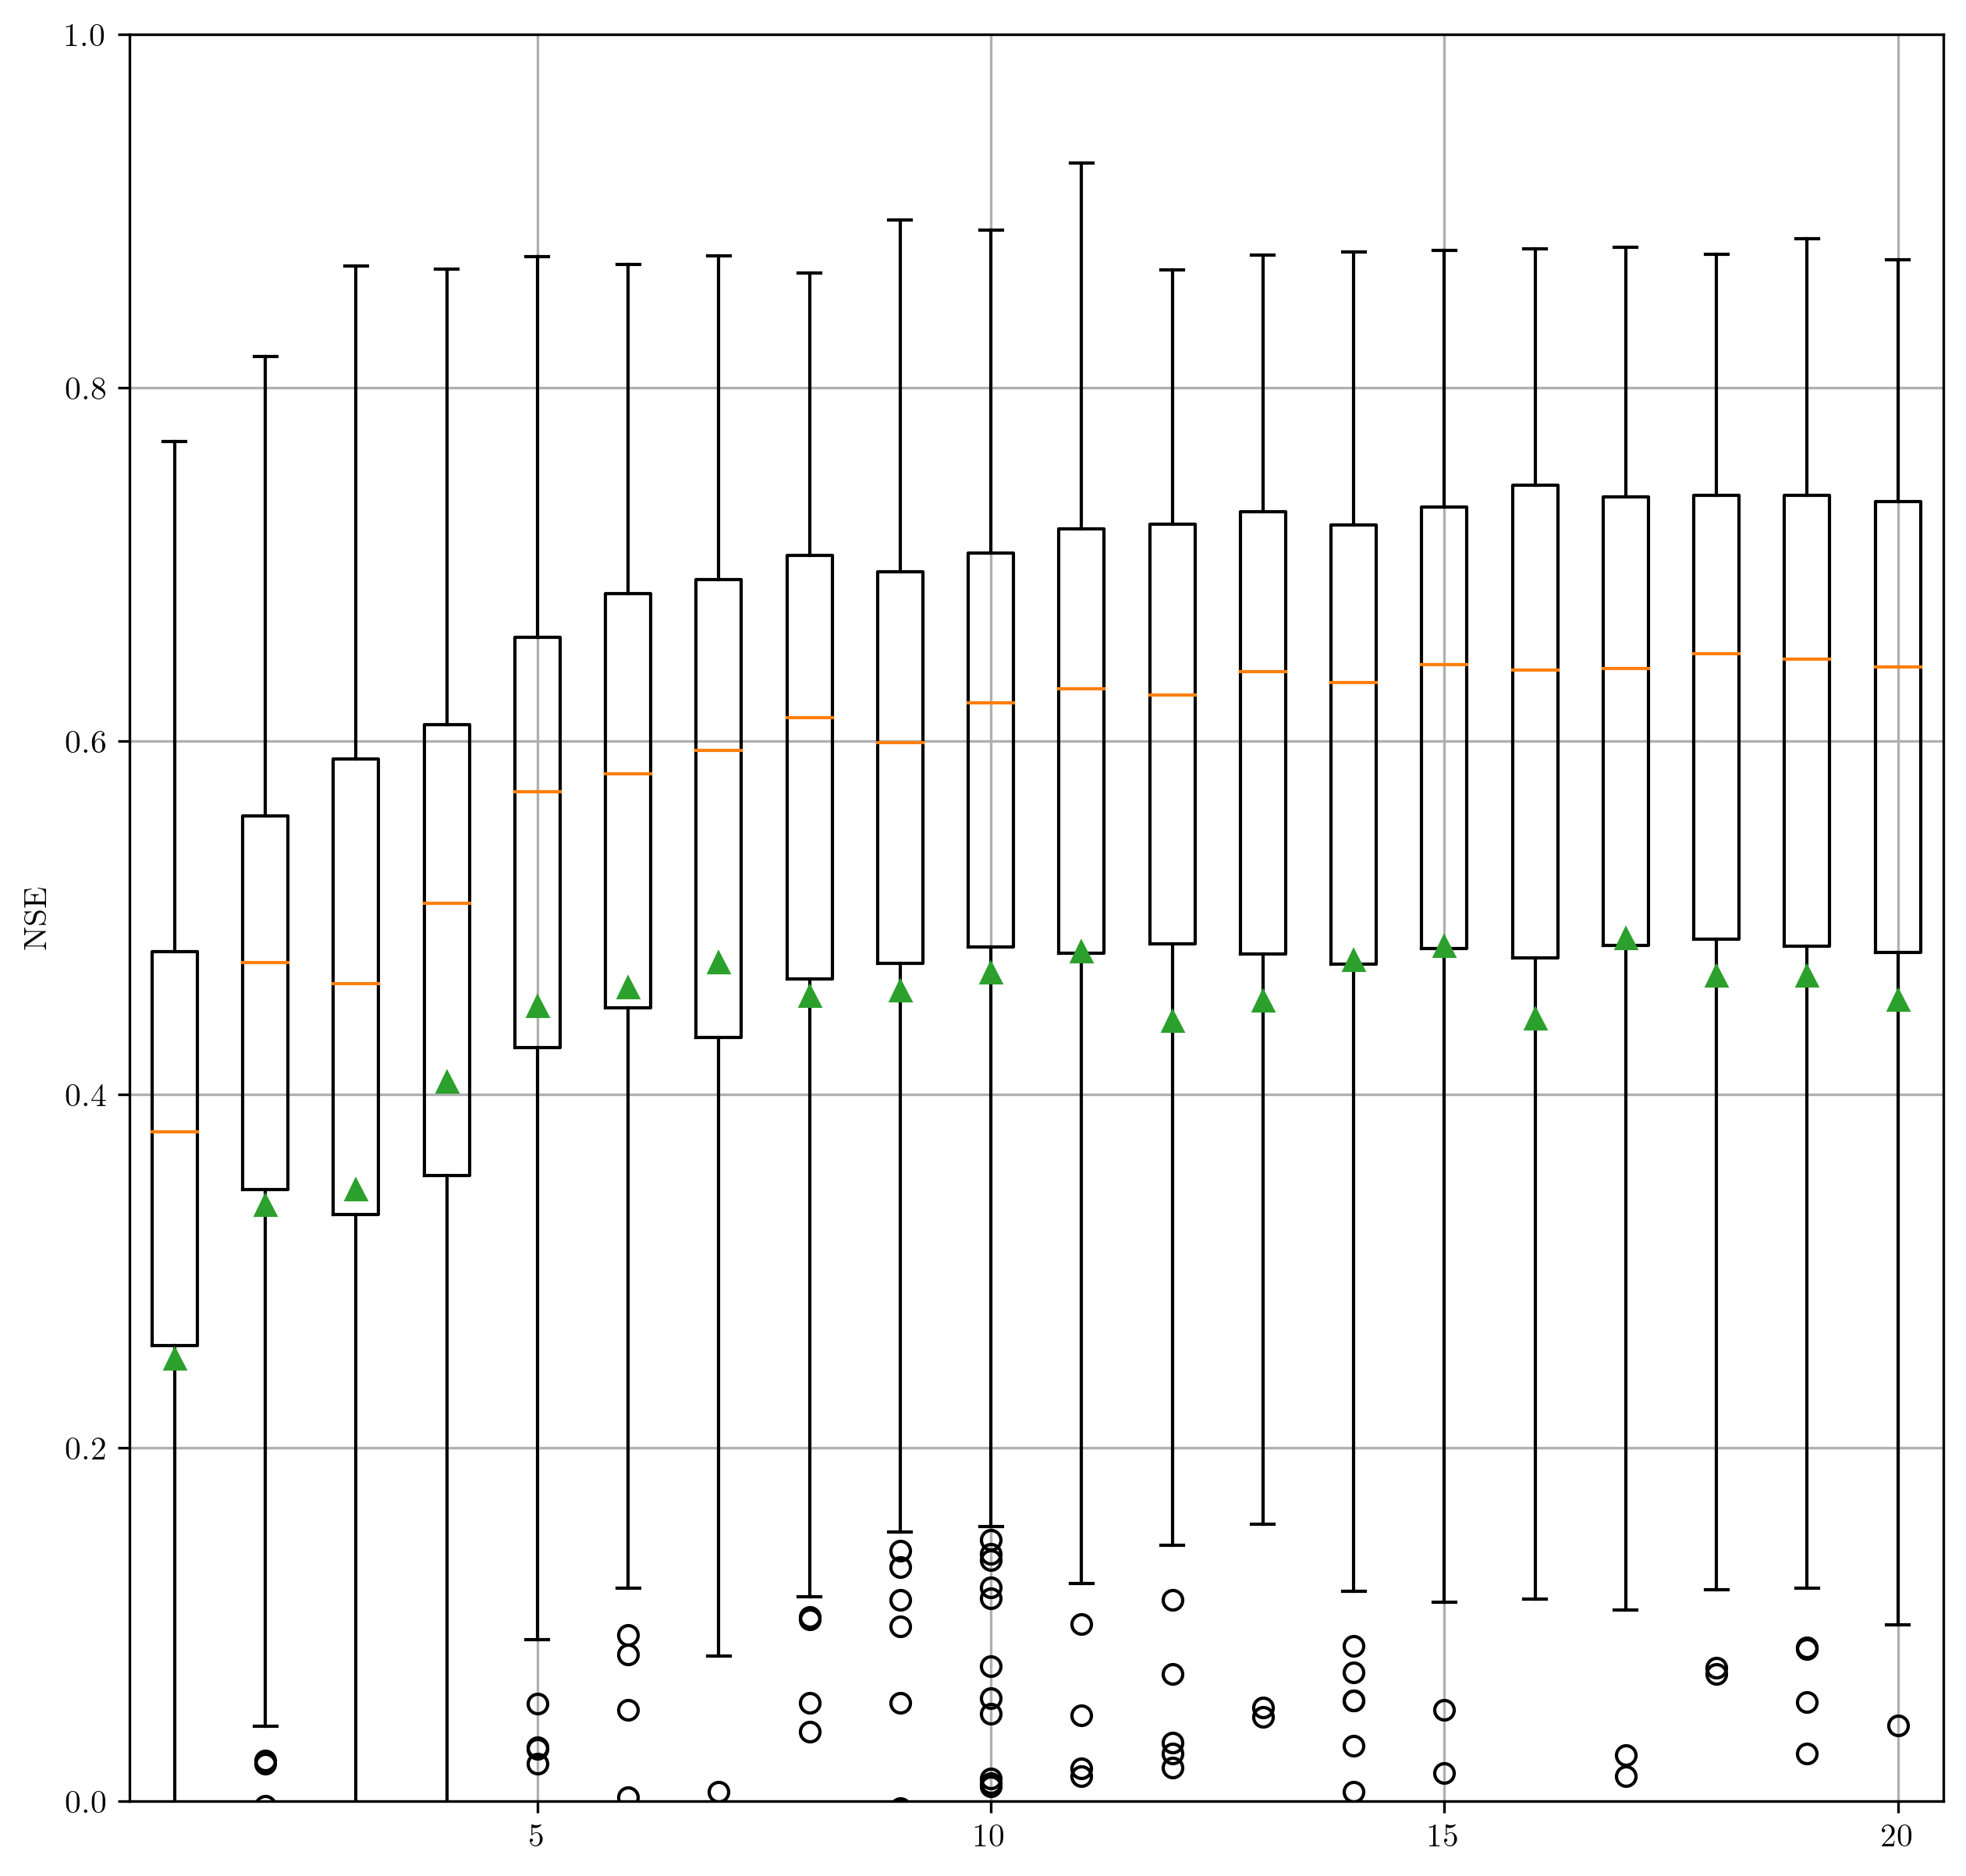

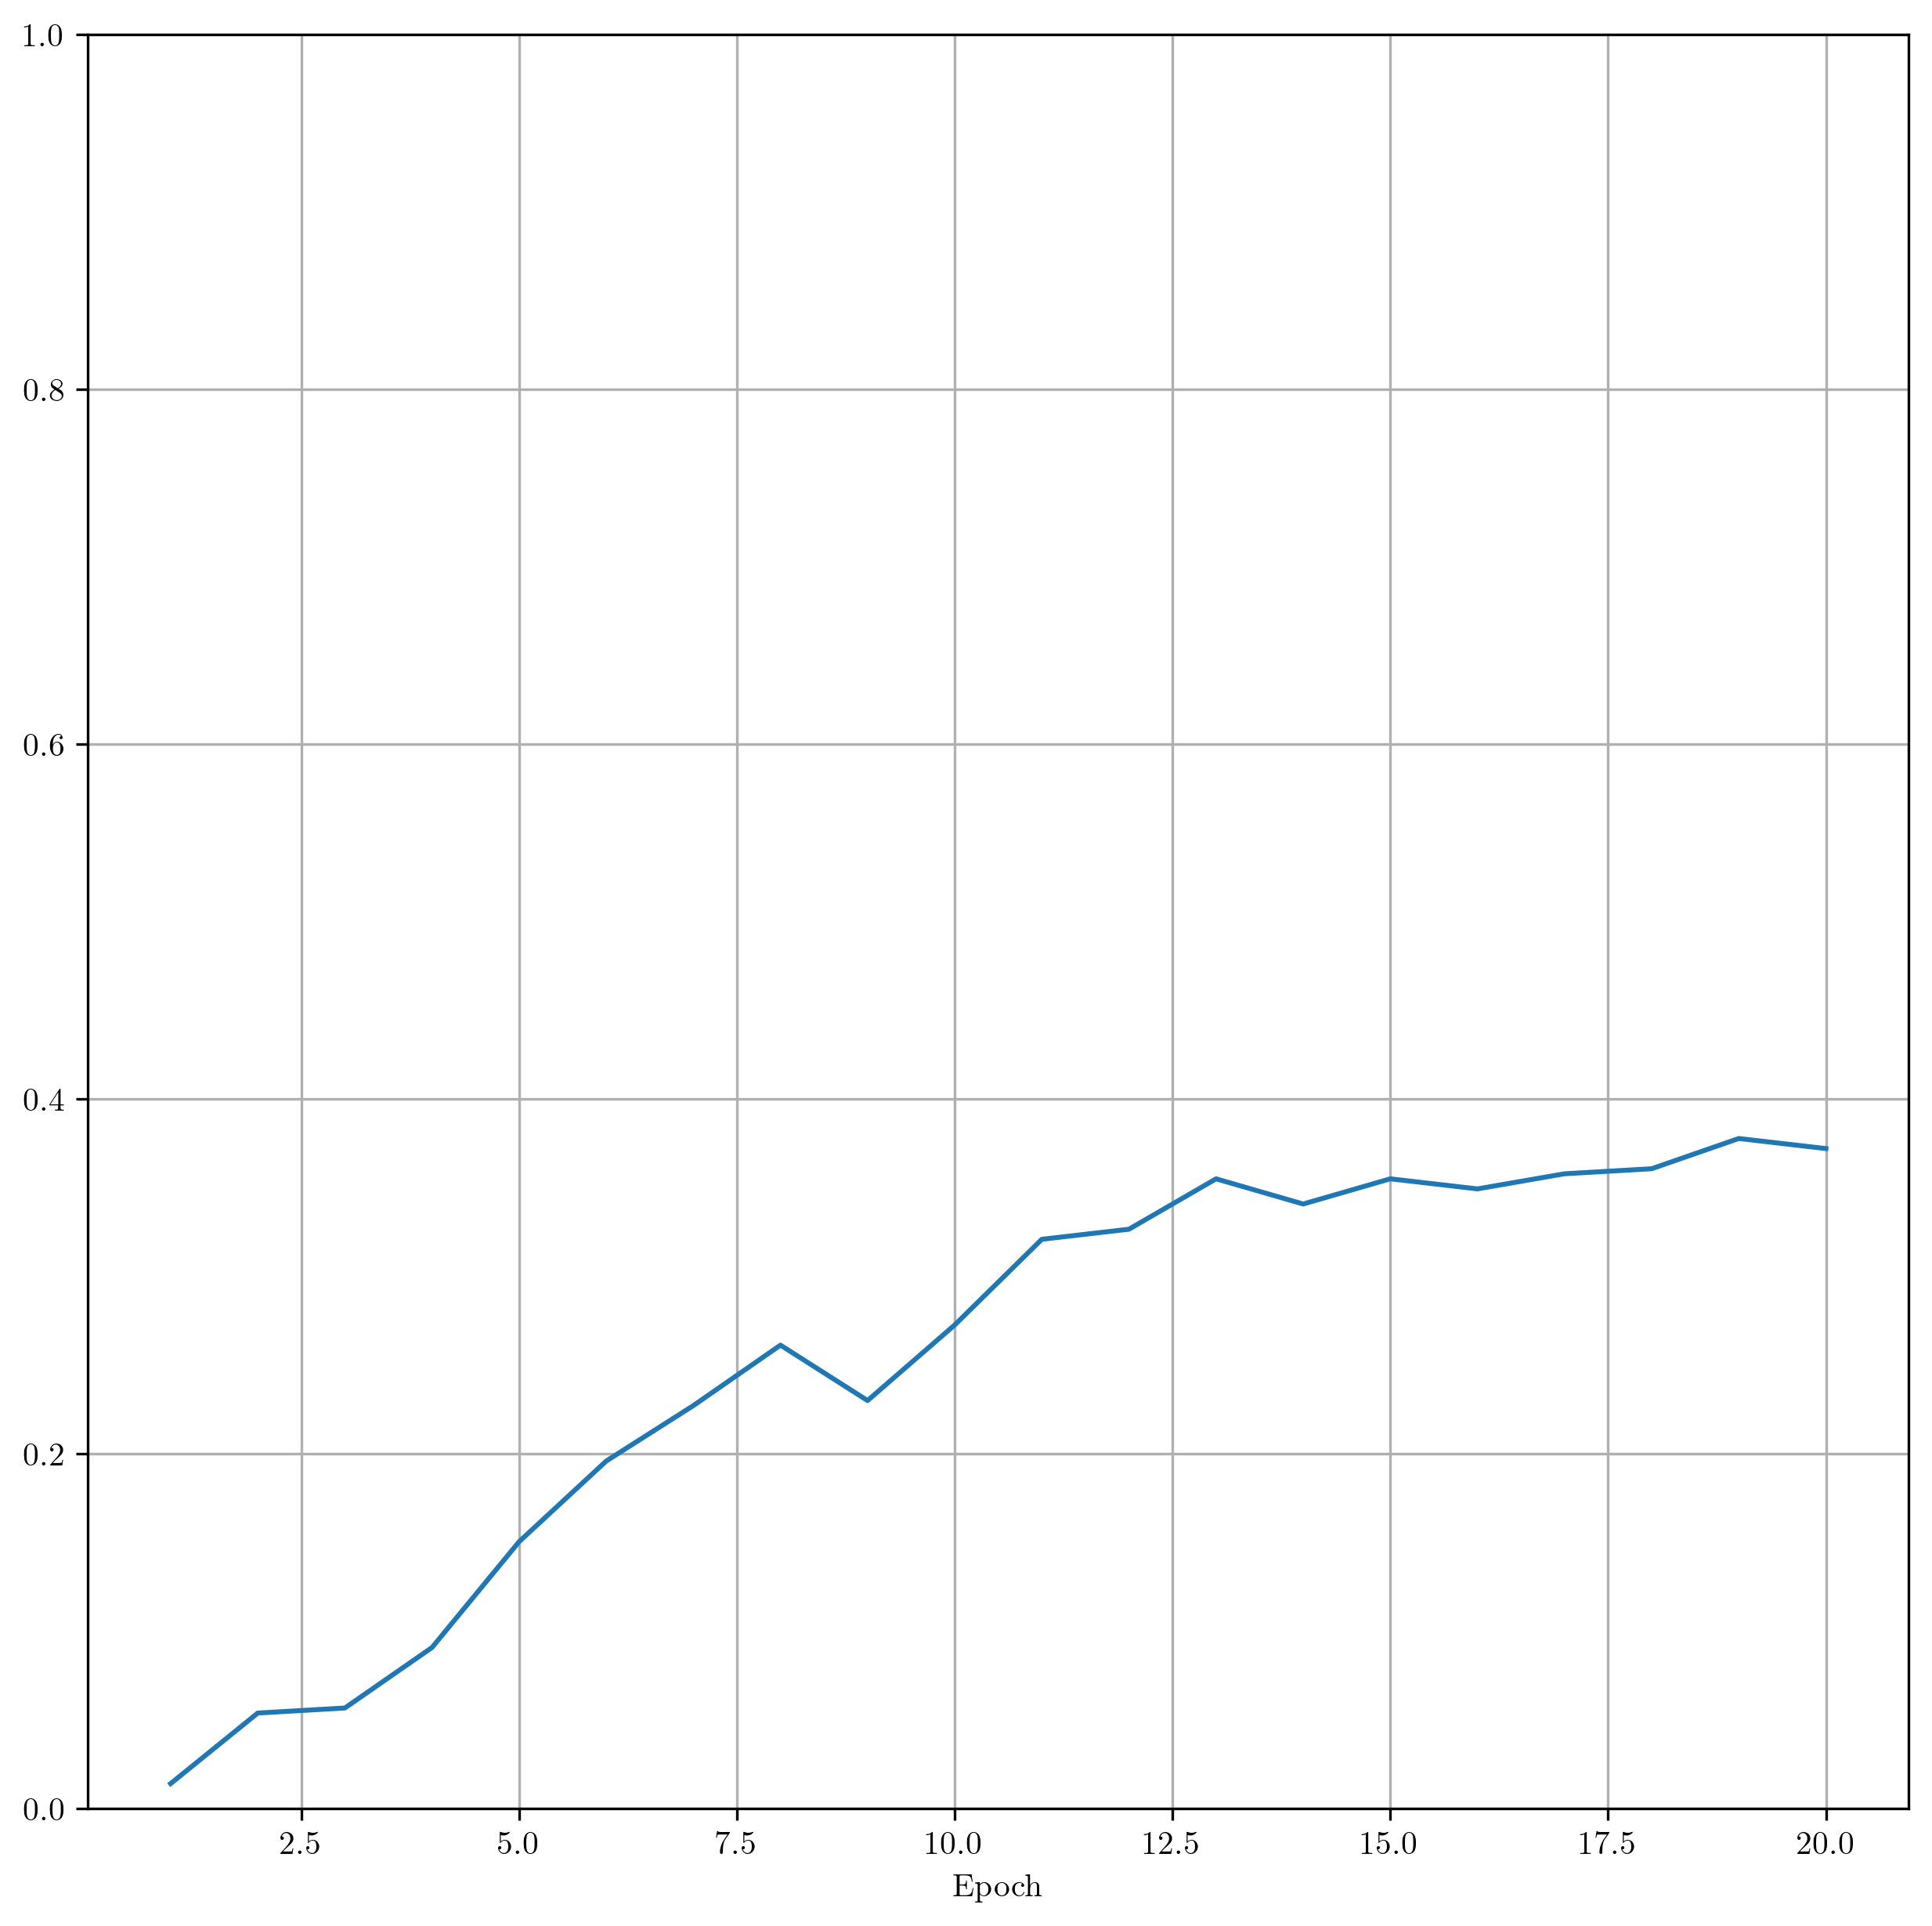

In [18]:
results_cv, results_debug = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us",
    5,
    "ealstm",
    "19970204",
    epoch=20,
    debug=True,
)
cv_nse = restructure_results(results_cv)
print(np.median(cv_nse[:,19]))
nse_boxplots(
    cv_nse,
)
plt.ylim([0, 1])
plt.show()

plot_fractions(cv_nse)
plt.ylim([0, 1])
plt.show()

### Kratzert's features vs no features in Camels-US:

100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


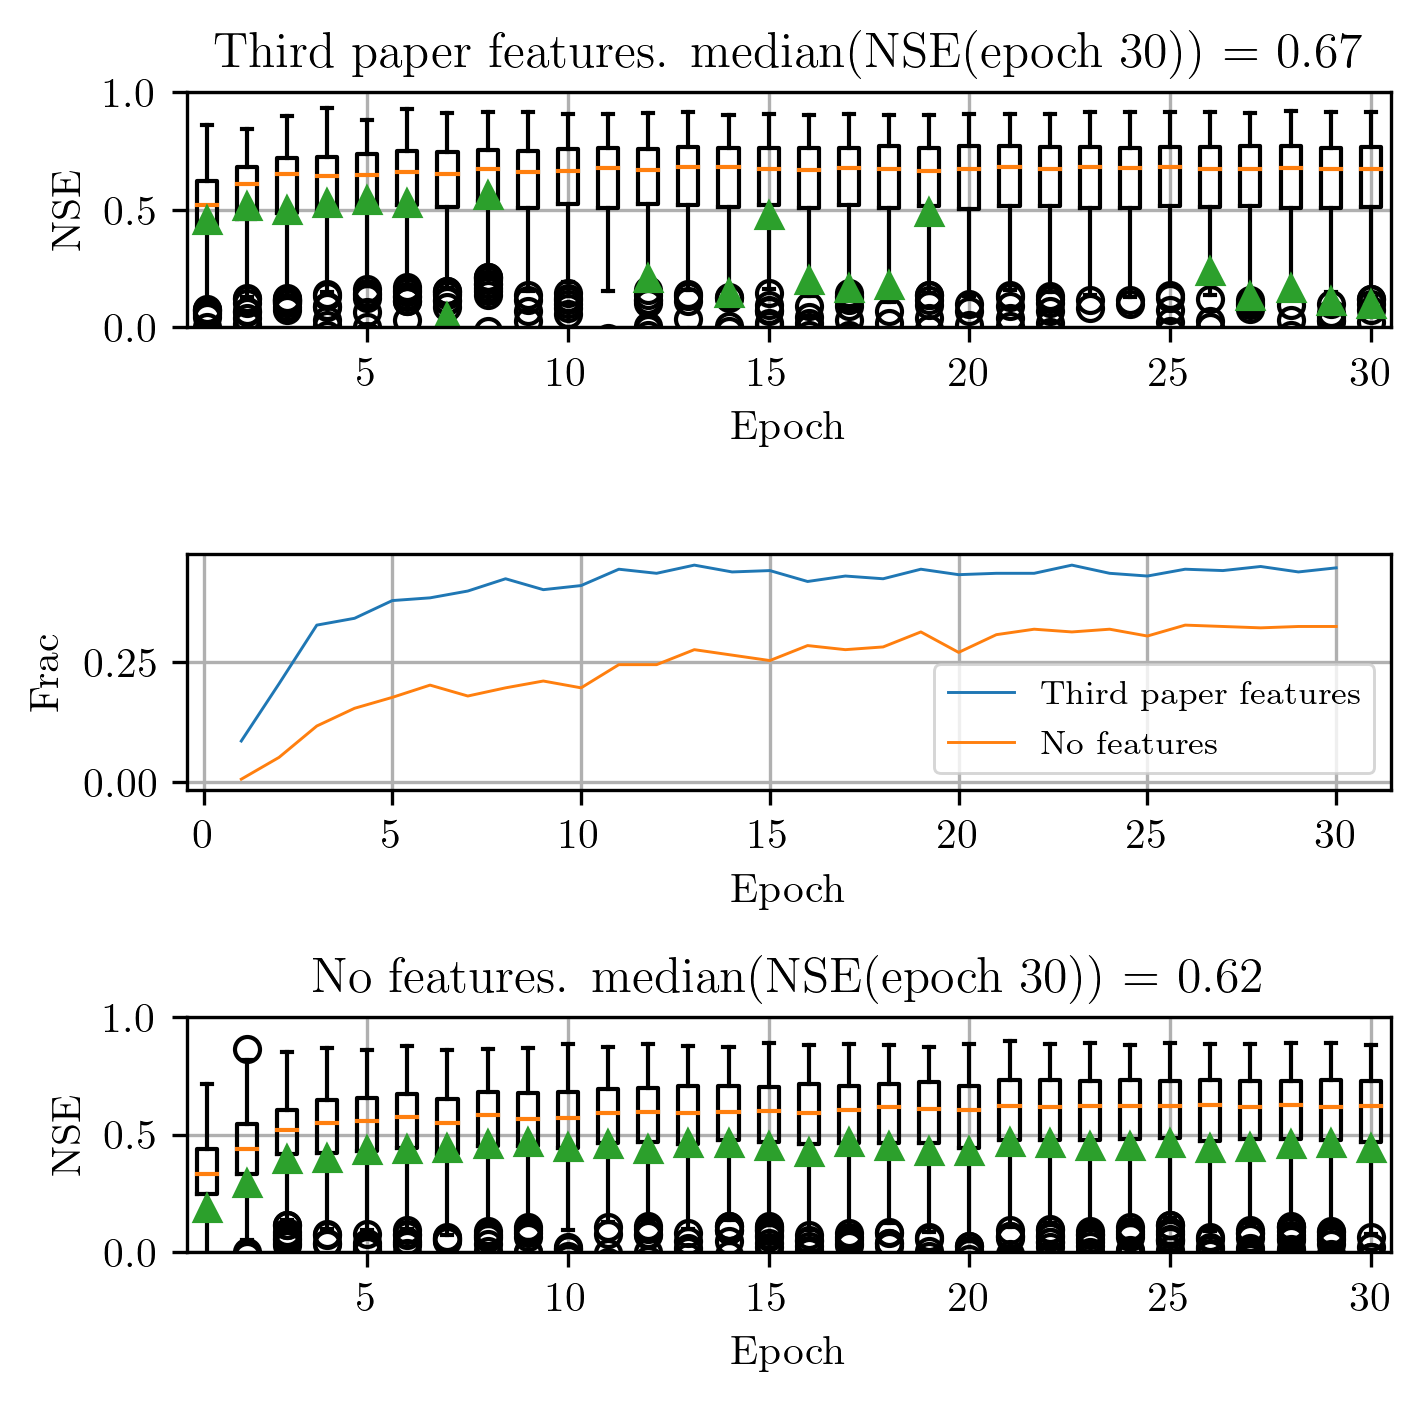

In [13]:
results_cv_kratzert_us = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us",
    5,
    "lstm",
    "19970204",
    epoch=30,
)
fig, axes = plt.subplots(3, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")
axes[2].set_ylim([0, 1])
axes[2].set_xlabel("Epoch")


cv_nse_kratzert_us = restructure_results(results_cv_kratzert_us)
nse_boxplots(cv_nse_kratzert_us, ax=axes[0])
axes[0].set_title(
    f"Third paper features. median(NSE(epoch 30)) = {np.median(cv_nse_kratzert_us[:,29]):.2f}"
)


plot_fractions(cv_nse_kratzert_us, ax=axes[1])

results_cv_no_features_us = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/no_features_kratzert_dropout_seq_cv_us",
    5,
    "lstm_no_static",
    "19970204",
    epoch=30,
)
cv_nse_no_features_us = restructure_results(results_cv_no_features_us)

nse_boxplots(cv_nse_no_features_us, ax=axes[2])
axes[2].set_title(
    f"No features. median(NSE(epoch 30)) = {np.median(cv_nse_no_features_us[:,29]):.2f}"
)

plot_fractions(cv_nse_no_features_us, ax=axes[1])
axes[1].legend(["Third paper features", "No features"])
axes[1].set_ylabel("Frac")
axes[1].grid()
fig.set_size_inches([4.7747, 4.7747])
fig.tight_layout()

In [14]:
results_cv_mixed = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed",
    5,
    "ealstm",
    "19970204",
    epoch=30,
)
cv_nse_mixed = restructure_results(results_cv_mixed)

100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


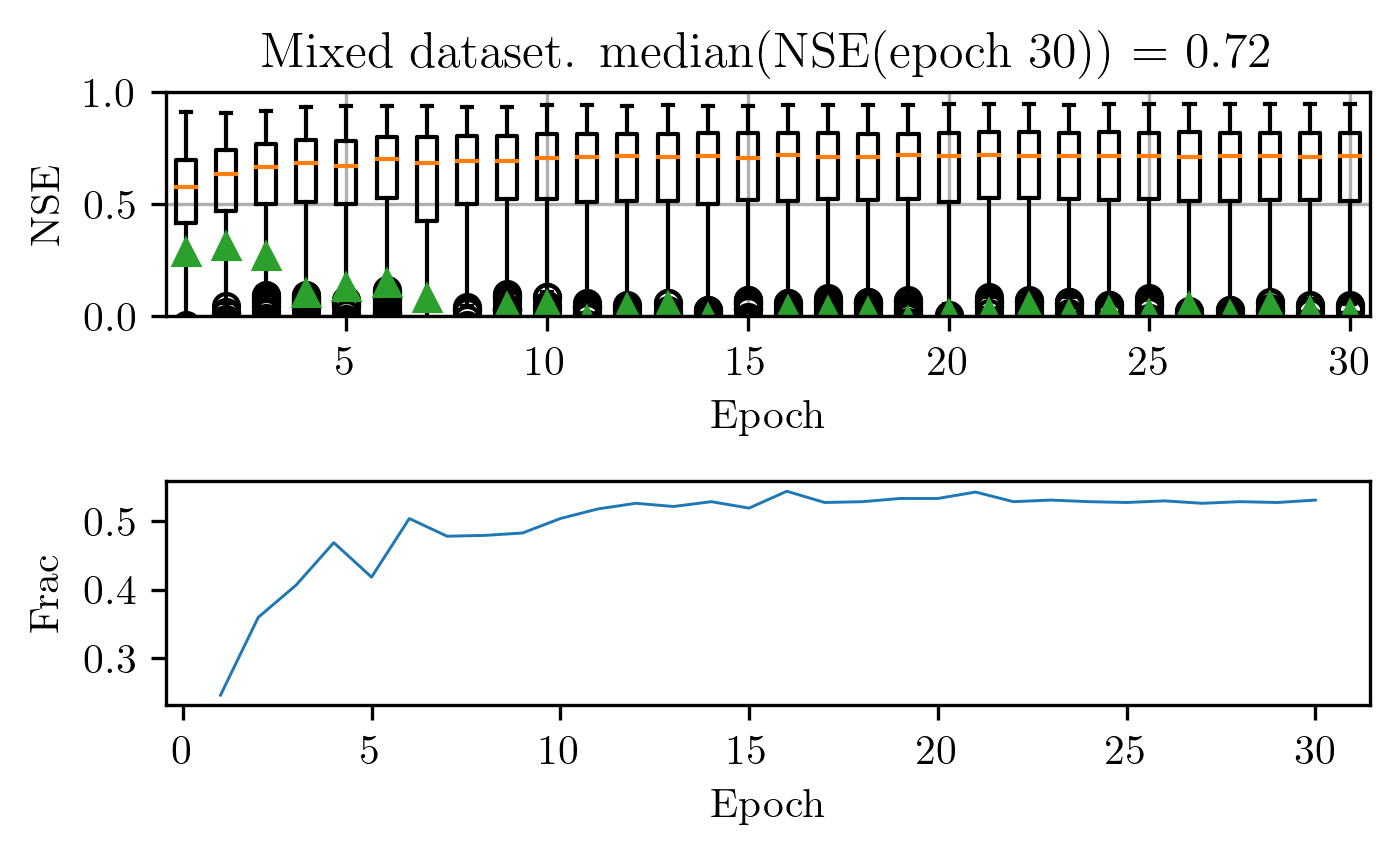

In [15]:
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")


nse_boxplots(cv_nse_mixed, ax=axes[0])
axes[0].set_title(
    f"Mixed dataset. median(NSE(epoch 30)) = {np.median(cv_nse_mixed[:,29]):.2f}"
)


plot_fractions(cv_nse_mixed, ax=axes[1])


axes[1].set_ylabel("Frac")
axes[1].grid()
fig.tight_layout()

In [16]:
results_cv_train_us_val_gb = defaultdict(lambda: defaultdict(int))
for i in tqdm(range(5)):
    results_ = load_results(
        folder=f"/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb/val_gb/{i}",
        model_type="ealstm",
        seed="19970204",
    )
    for epoch in results_:
        for basin in results_[epoch]:
            results_cv_train_us_val_gb[epoch][basin] += results_[epoch][basin] / 5
cv_nse_train_us_val_gb = restructure_results(results_cv_train_us_val_gb)

100%|██████████| 5/5 [01:16<00:00, 15.21s/it]


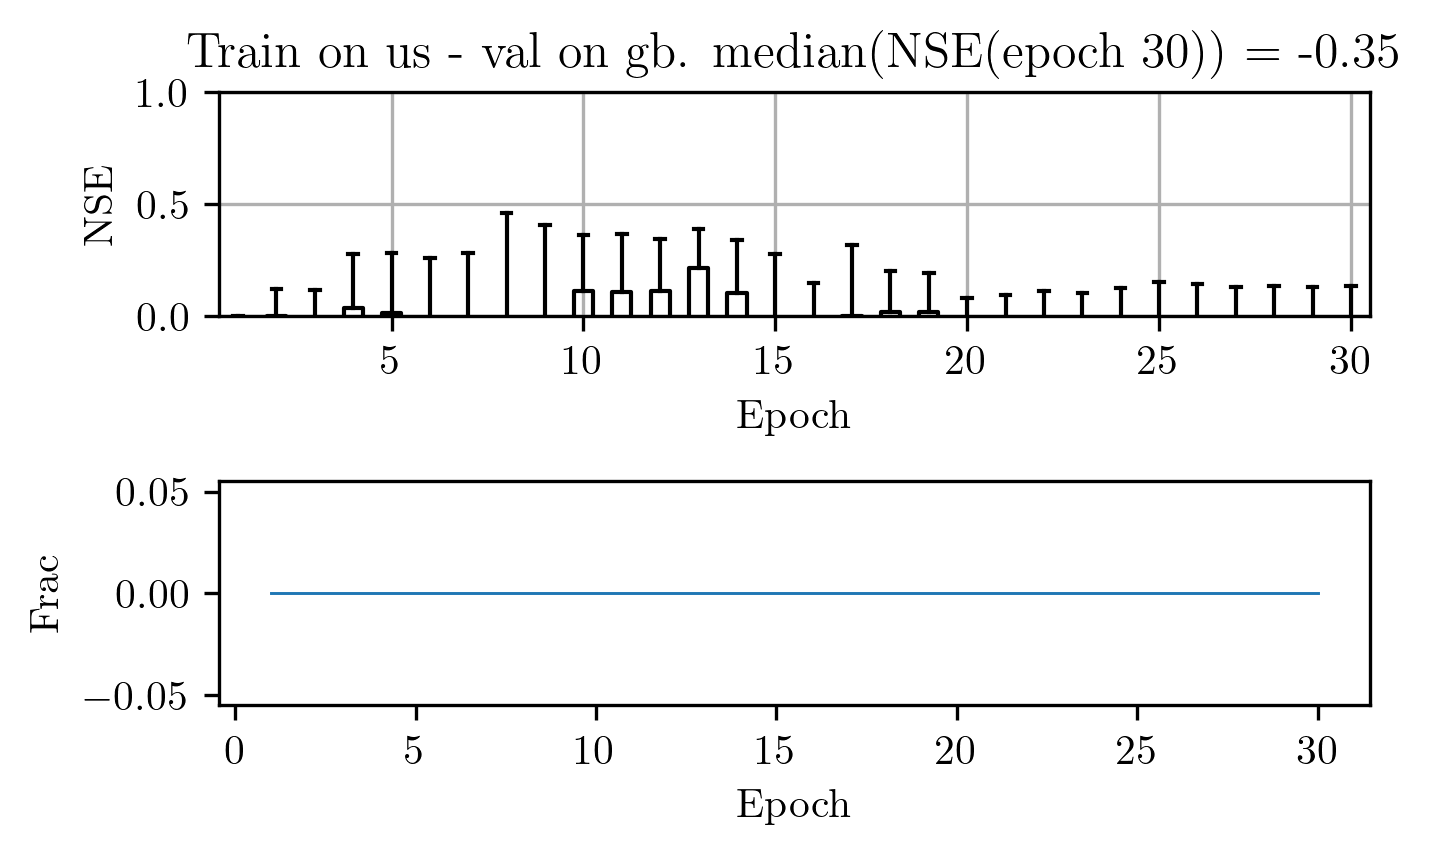

In [17]:
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")


nse_boxplots(cv_nse_train_us_val_gb, ax=axes[0])
axes[0].set_title(
    f"Train on us - val on gb. median(NSE(epoch 30)) = {np.median(cv_nse_train_us_val_gb[:,29]):.2f}"
)


plot_fractions(cv_nse_train_us_val_gb, ax=axes[1])


axes[1].set_ylabel("Frac")
axes[1].grid()
fig.tight_layout()

In [18]:
results_cv_train_gb_val_us = defaultdict(lambda: defaultdict(int))
for i in tqdm(range(5)):
    results_ = load_results(
        folder=f"/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_gb_val_us/val_us/{i}",
        model_type="ealstm",
        seed="19970204",
    )
    for epoch in results_:
        for basin in results_[epoch]:
            results_cv_train_gb_val_us[epoch][basin] += results_[epoch][basin] / 5
cv_nse_train_gb_val_us = restructure_results(results_cv_train_gb_val_us)

100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


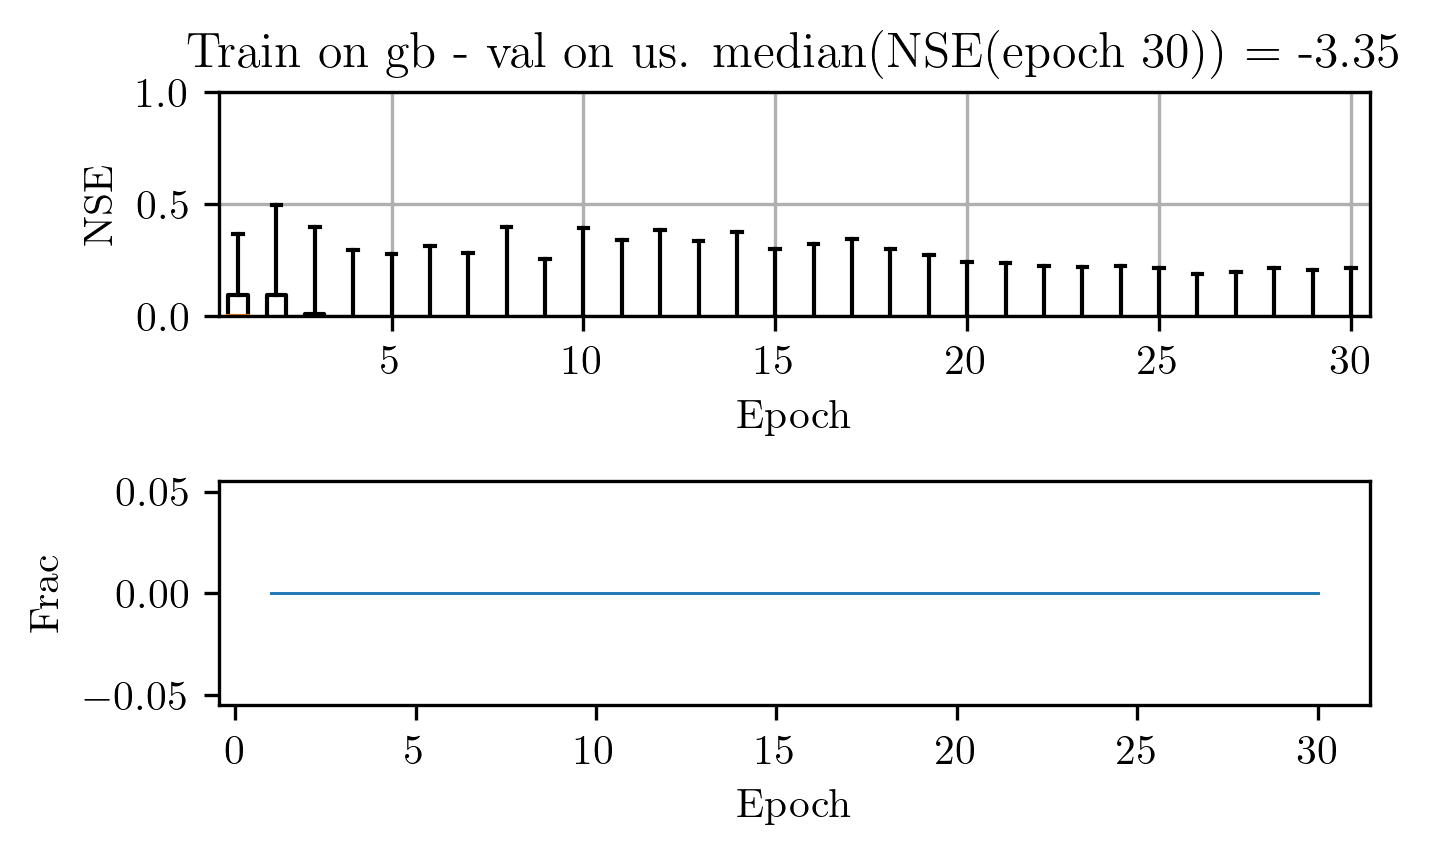

In [19]:
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")


nse_boxplots(cv_nse_train_gb_val_us, ax=axes[0])
axes[0].set_title(
    f"Train on gb - val on us. median(NSE(epoch 30)) = {np.median(cv_nse_train_gb_val_us[:,29]):.2f}"
)


plot_fractions(cv_nse_train_gb_val_us, ax=axes[1])


axes[1].set_ylabel("Frac")
axes[1].grid()
fig.tight_layout()

In [20]:
results_cv_train_us_val_us = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb",
    5,
    "ealstm",
    "19970204",
    epoch=30,
)
cv_nse_train_us_val_us = restructure_results(results_cv_train_us_val_us)

100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


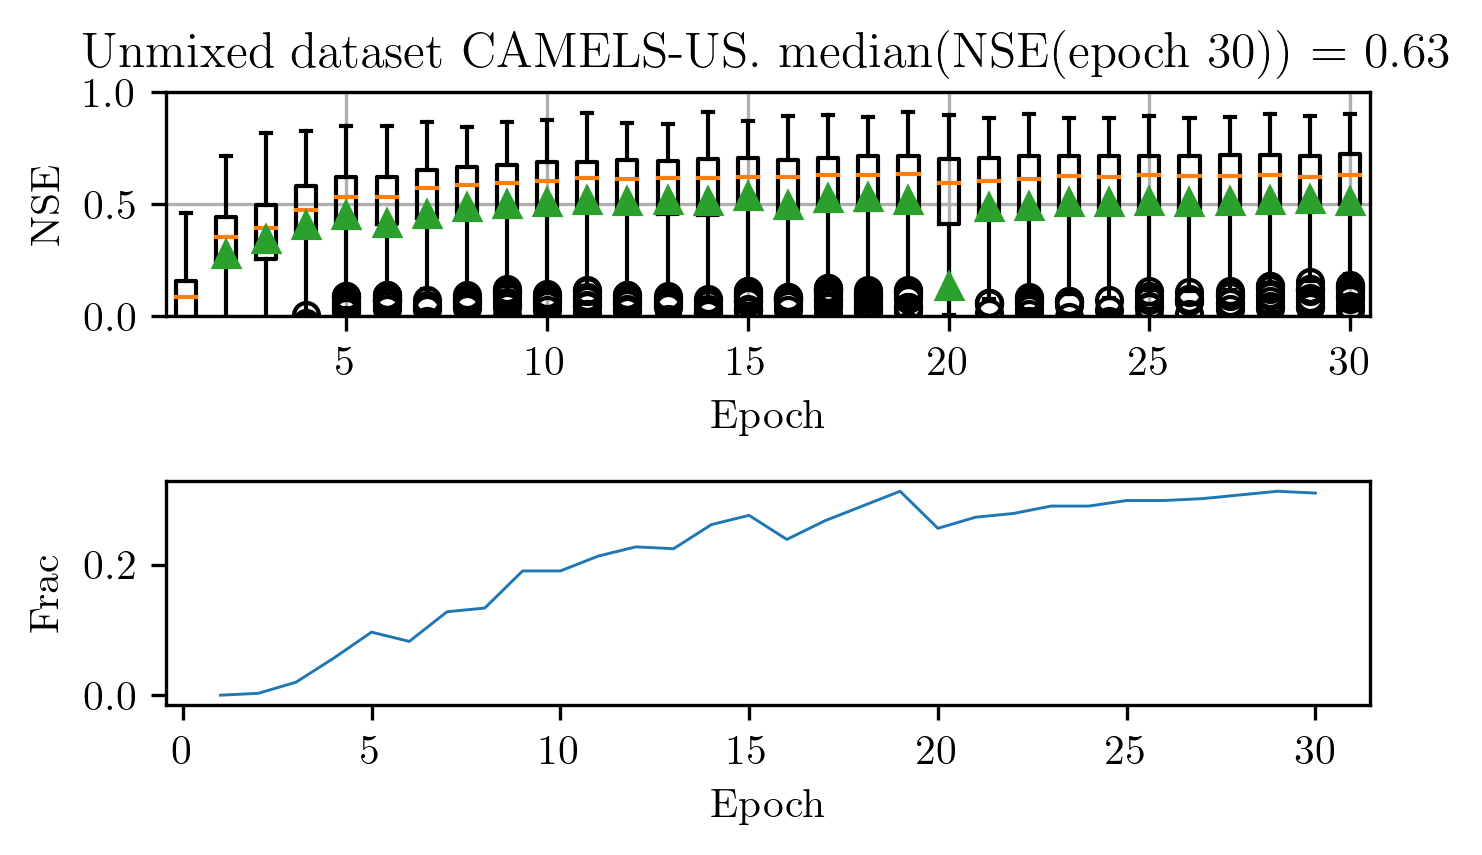

In [21]:
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")


nse_boxplots(cv_nse_train_us_val_us, ax=axes[0])
axes[0].set_title(
    f"Unmixed dataset CAMELS-US. median(NSE(epoch 30)) = {np.median(cv_nse_train_us_val_us[:,29]):.2f}"
)


plot_fractions(cv_nse_train_us_val_us, ax=axes[1])


axes[1].set_ylabel("Frac")
axes[1].grid()
fig.tight_layout()

In [22]:
results_cv_train_gb_val_gb = load_cv_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_gb_val_us",
    5,
    "ealstm",
    "19970204",
    epoch=30,
)
cv_nse_train_gb_val_gb = restructure_results(results_cv_train_gb_val_gb)

100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


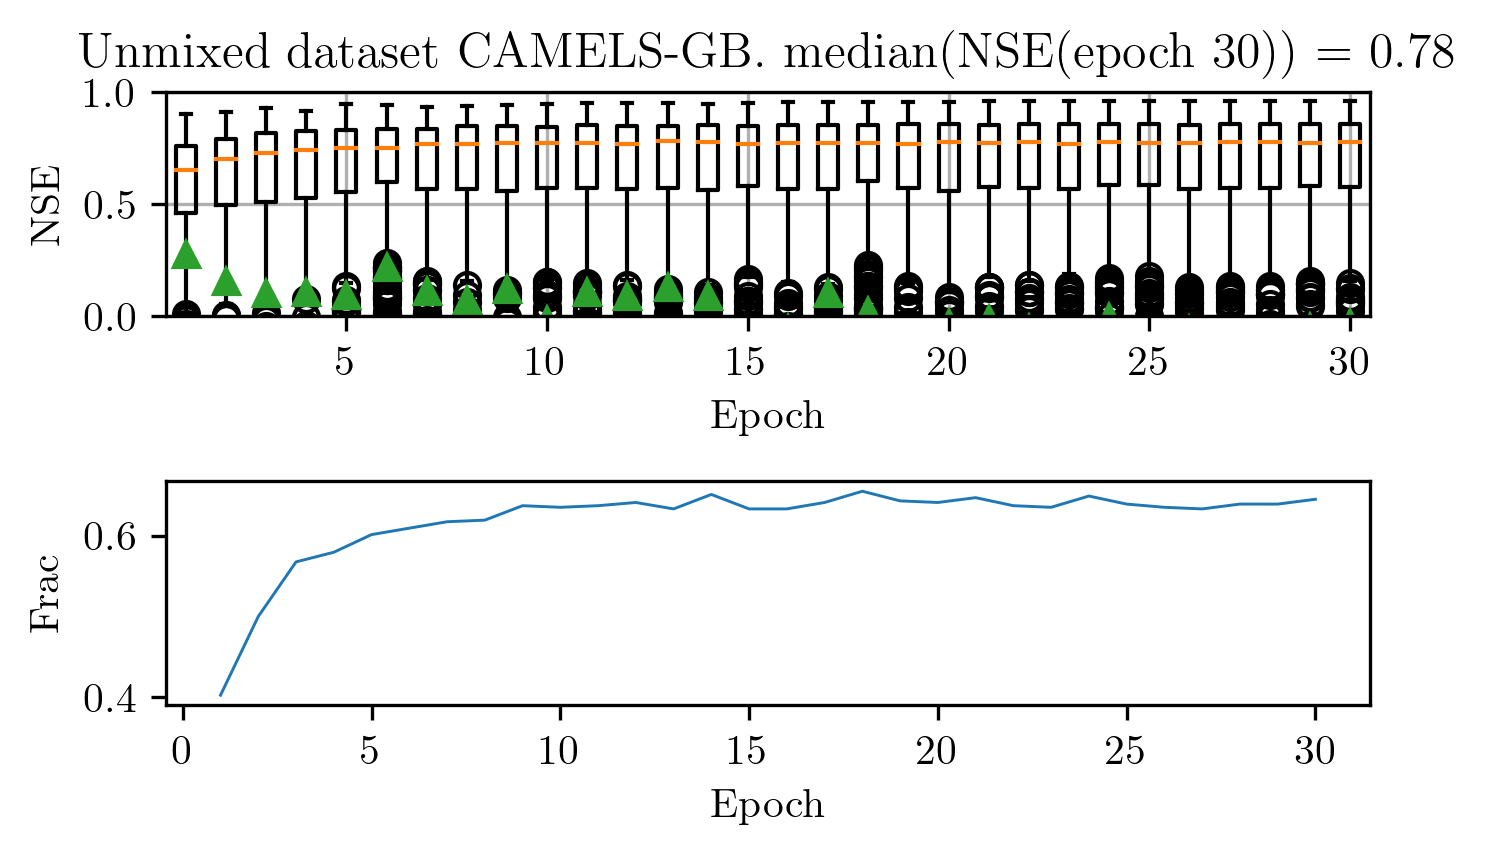

In [23]:
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
axes[0].set_ylim([0, 1])
axes[0].set_xlabel("Epoch")


nse_boxplots(cv_nse_train_gb_val_gb, ax=axes[0])
axes[0].set_title(
    f"Unmixed dataset CAMELS-GB. median(NSE(epoch 30)) = {np.median(cv_nse_train_gb_val_gb[:,29]):.2f}"
)


plot_fractions(cv_nse_train_gb_val_gb, ax=axes[1])


axes[1].set_ylabel("Frac")
axes[1].grid()
fig.tight_layout()

In [24]:
def plot_cdf(
    nse_dict: Dict[str, Dict[str, float]],
    ax: Optional[plt.Axes] = None,
    label: Optional[str] = None,
):
    if ax is None:
        fig, ax = plt.subplots()
    ax.step(
        sorted(list(nse_dict.values())), np.linspace(0, 1, len(nse_dict)), label=label
    )


def get_best_epoch(nse_dict: Dict[str, Dict[str, float]]) -> int:
    best = [0, -np.inf]
    for i, ep in enumerate(list(nse_dict.keys())):
        nse_list = list(nse_dict[ep].values())
        if nse_list == []:
            break
        median_nse = np.median(nse_list)
        if median_nse > best[1]:
            best = [i, median_nse]
    return best[0] + 1


def merge_nse_dicts(
    dict1: Dict[str, Dict[str, float]], dict2: Dict[str, Dict[str, float]]
) -> Dict[str, Dict[str, float]]:
    new_dict = defaultdict(dict)
    for epoch in dict1:
        for basin in dict1[epoch]:
            new_dict[epoch][basin] = dict1[epoch][basin]
        for basin in dict2[epoch]:
            new_dict[epoch][basin] = dict2[epoch][basin]
    return new_dict

In [100]:
def load_us_benchmarks(
    bench_root: Union[str, Path], basin_list: List
) -> Dict[str, Dict[str, float]]:
    bench_root = Path(bench_root)
    nse_values = defaultdict(dict)
    for basin in basin_list:
        if basin == "08082700":
            # Lazy hack
            continue
        ds = xr.open_dataset(bench_root / f"{basin}_benchmark_models.nc")
        try:
            for model in ds:
                nse_values[model][basin] = calc_nse(
                    obs=ds["QObs"].values, sim=ds[model].values
                )

        except KeyError as e:
            print(basin)
            raise e
    return nse_values


traditional_models_us = load_us_benchmarks(
    "/home/bernhard/git/datasets_masters/camels_us/benchmarks/netcdf",
    list(results_cv_kratzert_us["epoch_1"].keys()),
)

In [122]:
def load_nwm(
    nwm_bench_path: Union[Path, str],
    basin_list: List[str],
    camels_root: Union[Path, str],
) -> Dict[str, float]:
    nwm_bench_path = Path(nwm_bench_path)
    camels_root = Path(camels_root)
    indices = np.load(nwm_bench_path / "camels_id.npy")
    with open(nwm_bench_path / "nwm_daily.pkl", "rb") as infile:
        results_nwm = pickle.load(infile)
    for i, key in enumerate(list(results_nwm.keys())):
        # Only want basins that are in our validation set.
        if indices[i] in [int(basin) for basin in basin_list]:
            for basin in basin_list:
                if indices[i] == int(basin):
                    results_nwm[basin] = results_nwm.pop(key).dropna()
        else:
            del results_nwm[key]
    areas = load_attributes(
        db_path="/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/0/run_0902_1151_seed19970204/attributes.db",
        basins=basin_list,  # ["us_" + basin for basin in basin_list],
    )["area_gages2"]
    nse_values = {}
    for basin in tqdm(list(results_nwm.keys())):
        # area / 86.4 for m3 / s to mm / d
        results = results_nwm[basin]["NWM_RUN"]["1993-01-01":"2008-12-31"].values / (
            areas.loc[basin] / 86.4
        )
        qobs = load_discharge(
            camels_root=camels_root,
            basin=basin,
            area=areas.loc[basin] * 1e3 ** 2,
            dataset=["camels_us"],
        )["1993-01-01":"2008-12-31"].values
        nse_values[basin] = calc_nse(obs=qobs, sim=results)
    return nse_values


results_nwm = load_nwm(
    "/home/bernhard/git/datasets_masters/camels_us/benchmarks/nwm",
    list(results_cv_kratzert_us["epoch_1"].keys()),
    "/home/bernhard/git/datasets_masters/camels_us",
)

100%|██████████| 352/352 [00:15<00:00, 23.29it/s]


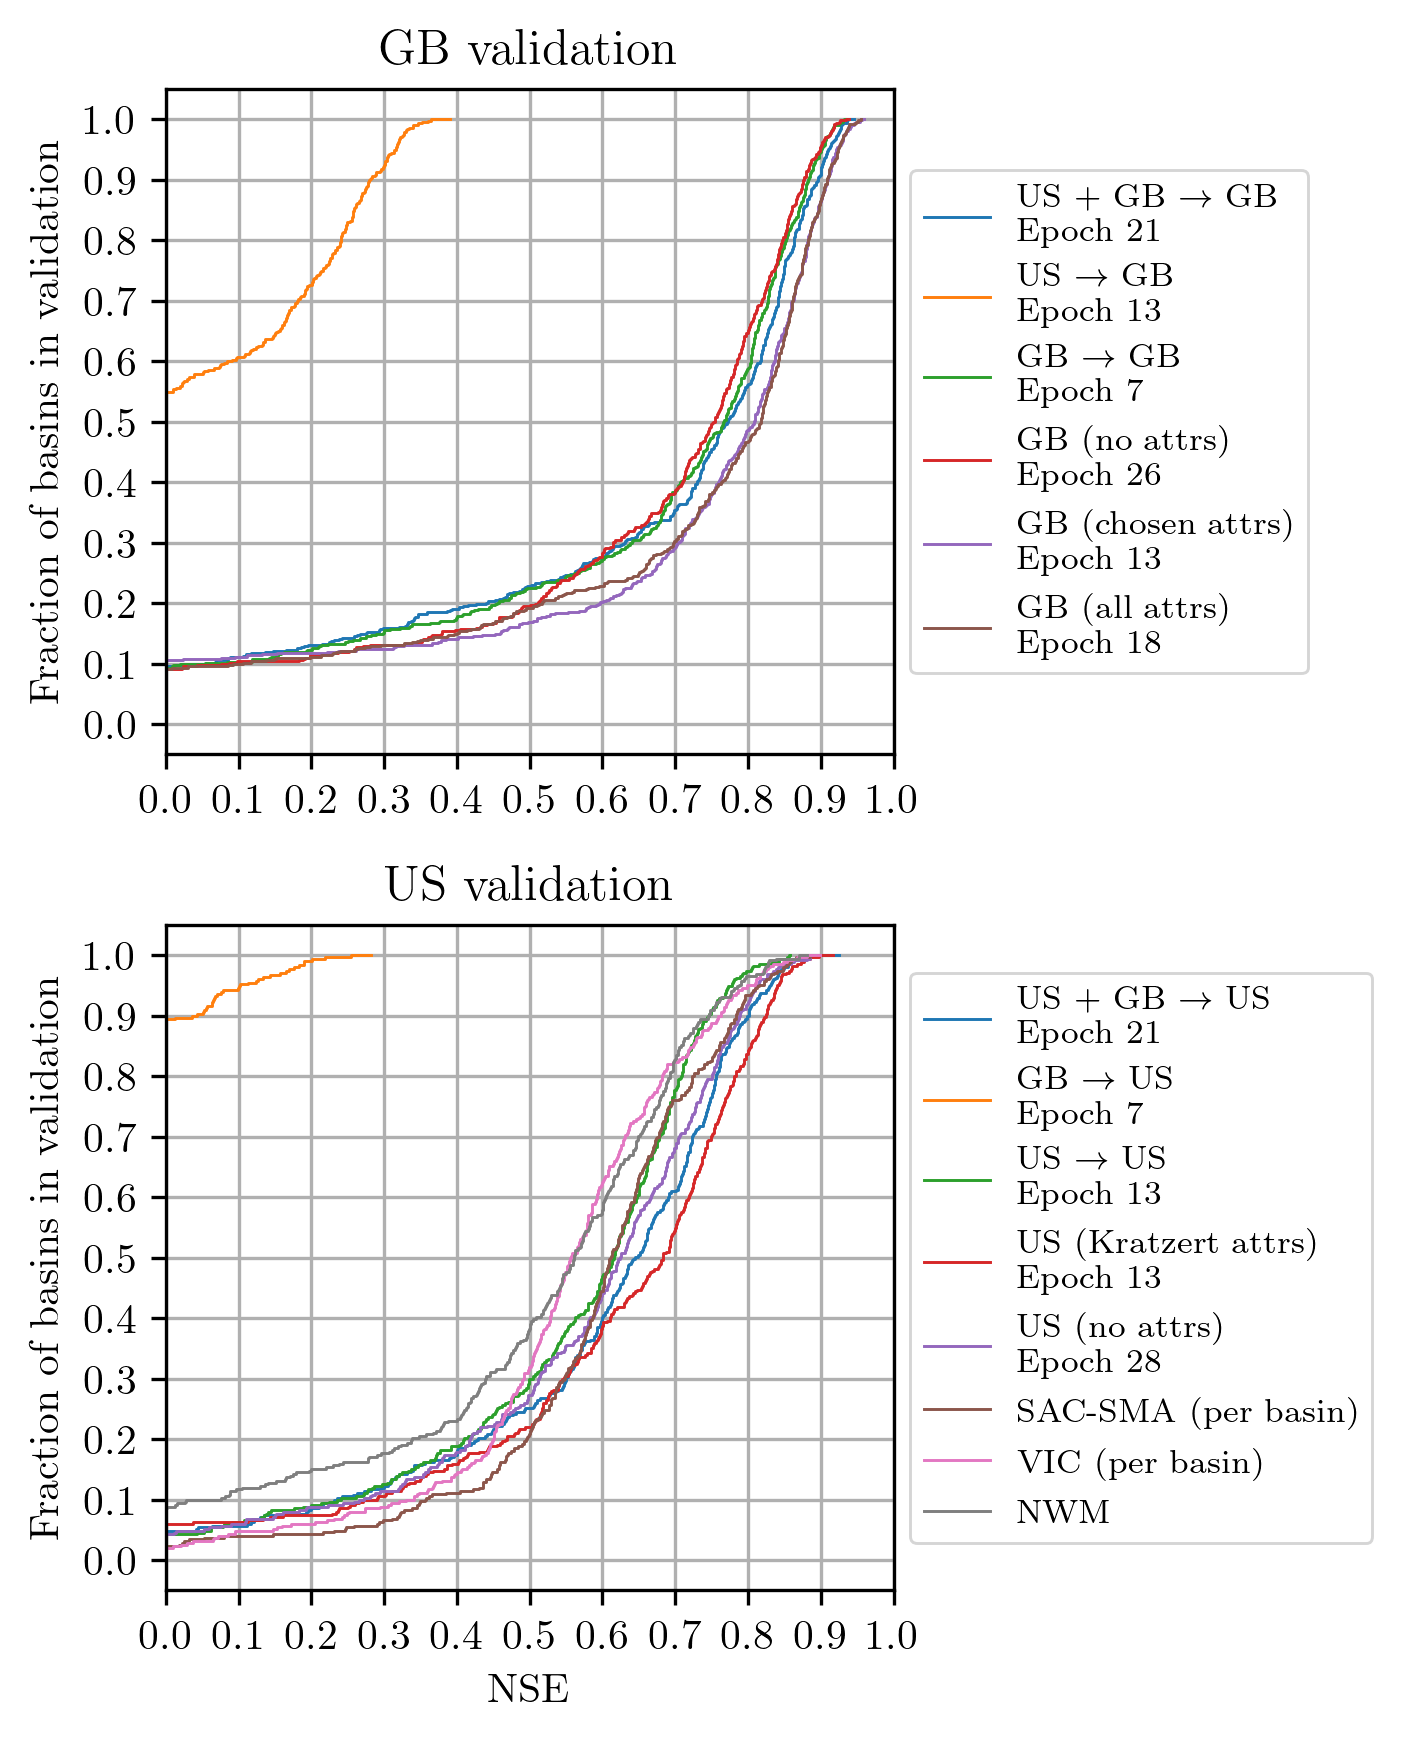

In [160]:
best_epoch_mixed = get_best_epoch(results_cv_mixed)
final_epoch_mixed = results_cv_mixed[f"epoch_{best_epoch_mixed}"]
results_final_us_mixed = {}
results_final_gb_mixed = {}
for basin, nse in final_epoch_mixed.items():
    if "us" in basin:
        results_final_us_mixed[basin[3:]] = nse
    elif "gb" in basin:
        results_final_gb_mixed[basin[3:]] = nse
    else:
        raise ValueError
fig, (ax_gb, ax_us) = plt.subplots(2, 1, figsize=[4.7747, 2.9509 * 2], sharex=False)

# colormap = plt.cm.nipy_spectral
# colors = [colormap(i) for i in np.linspace(0, 1, 12)]
# ax_us.set_prop_cycle("color", colors)
plot_cdf(
    nse_dict=results_final_us_mixed,
    ax=ax_us,
    label=fr"US + GB $\rightarrow$ US" "\n" fr"Epoch {best_epoch_mixed}",
)

plot_cdf(
    nse_dict=results_final_gb_mixed,
    ax=ax_gb,
    label=fr"US + GB $\rightarrow$ GB" "\n" fr"Epoch {best_epoch_mixed}",
)


combined_us = merge_nse_dicts(results_cv_train_us_val_us, results_cv_train_us_val_gb)
best_epoch_train_us = get_best_epoch(combined_us)
best_epoch_train_us_val_gb = get_best_epoch(results_cv_train_us_val_gb)
plot_cdf(
    nse_dict=results_cv_train_us_val_gb[f"epoch_{best_epoch_train_us}"],
    ax=ax_gb,
    label=fr"US $\rightarrow$ GB" "\n" fr"Epoch {best_epoch_train_us}",
)

combined_gb = merge_nse_dicts(results_cv_train_gb_val_us, results_cv_train_gb_val_gb)
best_epoch_train_gb = get_best_epoch(combined_gb)
plot_cdf(
    nse_dict=results_cv_train_gb_val_us[f"epoch_{best_epoch_train_gb}"],
    ax=ax_us,
    label=fr"GB $\rightarrow$ US" "\n" fr"Epoch {best_epoch_train_gb}",
)

plot_cdf(
    nse_dict=results_cv_train_gb_val_gb[f"epoch_{best_epoch_train_gb}"],
    ax=ax_gb,
    label=fr"GB $\rightarrow$ GB" "\n" fr"Epoch {best_epoch_train_gb}",
)

plot_cdf(
    nse_dict=results_cv_train_us_val_us[f"epoch_{best_epoch_train_us}"],
    ax=ax_us,
    label=fr"US $\rightarrow$ US" "\n" fr"Epoch {best_epoch_train_us}",
)

best_epoch_kratzert_us = get_best_epoch(results_cv_kratzert_us)
plot_cdf(
    nse_dict=results_cv_kratzert_us[f"epoch_{best_epoch_kratzert_us}"],
    ax=ax_us,
    label=f"US (Kratzert attrs)" "\n" fr"Epoch {best_epoch_kratzert_us}",
)


best_epoch_no_features_us = get_best_epoch(results_cv_no_features_us)
plot_cdf(
    nse_dict=results_cv_no_features_us[f"epoch_{best_epoch_no_features_us}"],
    ax=ax_us,
    label=f"US (no attrs)" "\n" fr"Epoch {best_epoch_no_features_us}",
)

best_epoch_no_features_gb = get_best_epoch(results_no_features_cv)
plot_cdf(
    nse_dict=results_no_features_cv[f"epoch_{best_epoch_no_features_gb}"],
    ax=ax_gb,
    label=f"GB (no attrs)" "\n" fr"Epoch {best_epoch_no_features_gb}",
)

best_epoch_chosen_gb = get_best_epoch(results_chosen_cv)
plot_cdf(
    nse_dict=results_chosen_cv[f"epoch_{best_epoch_chosen_gb}"],
    ax=ax_gb,
    label=f"GB (chosen attrs)" "\n" fr"Epoch {best_epoch_chosen_gb}",
)

best_epoch_all_features_gb = get_best_epoch(results_all_features_fixed_cv)
plot_cdf(
    nse_dict=results_all_features_fixed_cv[f"epoch_{best_epoch_all_features_gb}"],
    ax=ax_gb,
    label=f"GB (all attrs)" "\n" fr"Epoch {best_epoch_all_features_gb}",
)

plot_cdf(
    nse_dict=traditional_models_us["SAC_SMA"], ax=ax_us, label="SAC-SMA (per basin)"
)
plot_cdf(nse_dict=traditional_models_us["VIC_basin"], ax=ax_us, label="VIC (per basin)")

plot_cdf(nse_dict=results_nwm, ax=ax_us, label="NWM")

ax_gb.set_title("GB validation")
ax_us.set_title("US validation")
ax_gb.set_ylabel("Fraction of basins in validation")
ax_us.set_ylabel("Fraction of basins in validation")
ax_us.set_xlabel("NSE")
ax_gb.set_yticks(np.linspace(0, 1, 11))
ax_us.set_yticks(np.linspace(0, 1, 11))
ax_gb.set_xticks(np.linspace(0, 1, 11))
ax_us.set_xticks(np.linspace(0, 1, 11))
ax_gb.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax_us.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax_gb.set_xlim([0, 1])
ax_us.set_xlim([0, 1])
ax_gb.grid()
ax_us.grid()
fig.tight_layout()
fig_path = Path("../doc/thesis/figures/CDFs")
fig_path.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_path / "mixed_model_comparisons.pdf")
plt.show()

Vi har ungauged CDF med modell tren på både US og GB.

CFG ser ca. like bra ut som SAC-SMA benchmarken på gauged basins på CAMELS-US.

* All features GB
* All features US
* GB on common features
* US on common features
* Mixed model

## Creating comparison matrix

In [157]:
def create_comparison_matrix(median_nse_dict: Dict[str, float]) -> pd.DataFrame:
    diff = defaultdict(dict)
    models = list(median_nse_dict.keys())
    for model1 in models:
        for model2 in models:
            diff[model1][model2] = median_nse_dict[model1] - median_nse_dict[model2]
    df = pd.DataFrame.from_dict(diff)
    return df


median_nses_gb = {
    "GB+US": np.median(list(results_final_gb_mixed.values())),
    "US": np.median(
        list(results_cv_train_us_val_gb[f"epoch_{best_epoch_train_us}"].values())
    ),
    "GB": np.median(
        list(results_cv_train_gb_val_gb[f"epoch_{best_epoch_train_gb}"].values())
    ),
    "all features": np.median(
        list(
            results_all_features_fixed_cv[
                f"epoch_{best_epoch_all_features_gb}"
            ].values()
        )
    ),
    "chosen features": np.median(
        list(results_chosen_cv[f"epoch_{best_epoch_chosen_gb}"].values())
    ),
    "no features": np.median(
        list(results_no_features_cv[f"epoch_{best_epoch_no_features_gb}"].values())
    ),
}
create_comparison_matrix(median_nse_dict=median_nses_gb)

,GB+US,US,GB,all features,chosen features,no features
GB+US,0.000000,-0.905981,-0.004700,0.045460,0.036734,-0.018156
US,0.905981,0.000000,0.901281,0.951441,0.942715,0.887826
GB,0.004700,-0.901281,0.000000,0.050160,0.041434,-0.013456
all features,-0.045460,-0.951441,-0.050160,0.000000,-0.008726,-0.063616
chosen features,-0.036734,-0.942715,-0.041434,0.008726,0.000000,-0.054890
no features,0.018156,-0.887826,0.013456,0.063616,0.054890,0.000000


In [166]:
median_nses_us = {
    "GB+US": np.median(list(results_final_us_mixed.values())),
    "US": np.median(
        list(results_cv_train_us_val_us[f"epoch_{best_epoch_train_us}"].values())
    ),
    "GB": np.median(
        list(results_cv_train_gb_val_us[f"epoch_{best_epoch_train_gb}"].values())
    ),
    "Kratzert features": np.median(
        list(results_cv_kratzert_us[f"epoch_{best_epoch_kratzert_us}"].values())
    ),
    "no features": np.median(
        list(results_cv_no_features_us[f"epoch_{best_epoch_no_features_us}"].values())
    ),
    "SAC-SMA (basin-wise)": np.median(list(traditional_models_us["SAC_SMA"].values())),
    "VIC (basin-wise)": np.median(list(traditional_models_us["VIC_basin"].values())),
    "NWM (unsure, check!!)": np.median(list(results_nwm.values())),
}
create_comparison_matrix(median_nse_dict=median_nses_us)

,GB+US,US,GB,Kratzert features,no features,SAC-SMA (basin-wise),VIC (basin-wise),"NWM (unsure, check!!)"
GB+US,0.000000,-0.030436,-1.436026,0.036762,-0.021394,-0.035179,-0.089317,-0.085419
US,0.030436,0.000000,-1.405590,0.067198,0.009041,-0.004743,-0.058881,-0.054983
GB,1.436026,1.405590,0.000000,1.472788,1.414632,1.400847,1.346709,1.350607
Kratzert features,-0.036762,-0.067198,-1.472788,0.000000,-0.058156,-0.071941,-0.126079,-0.122181
no features,0.021394,-0.009041,-1.414632,0.058156,0.000000,-0.013785,-0.067923,-0.064025
SAC-SMA (basin-wise),0.035179,0.004743,-1.400847,0.071941,0.013785,0.000000,-0.054138,-0.050240
VIC (basin-wise),0.089317,0.058881,-1.346709,0.126079,0.067923,0.054138,0.000000,0.003898
"NWM (unsure, check!!)",0.085419,0.054983,-1.350607,0.122181,0.064025,0.050240,-0.003898,0.000000


## Checking numerical values of features in CAMELS-US and CAMELS-GB

In [190]:
val_basin_list = results_cv_mixed["epoch_1"].keys()
val_attributes = load_attributes(
    basins=val_basin_list,
    db_path="/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed/0/run_0203_1133_seed19970204/attributes.db",
)
val_attributes_gb = val_attributes.loc[val_attributes.index.str.contains("gb")]
val_attributes_us = val_attributes.loc[val_attributes.index.str.contains("us")]
val_attributes

/home/bernhard/git/ealstm_regional_modeling_camels_gb/camelsml/datautils.py:258: UserWarning: Dropped elev_mean because of NaN!
  warnings.warn(f"Dropped {feature} because of NaN!")


,soil_depth_pelletier,frac_forest,gvf_max,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc,organic_perc
gauge_id,,,,,,,,,,,,,,,,,,,
gb_10002,13.210000,0.0930,0.981500,2.290000,1.260000,-0.030000,0.030000,0.550000,13.96,1.160000,207.89,3.170000,325.72,43.810000,1.340000,0.409800,0.356000,0.234200,0.0522
gb_10003,7.520000,0.0780,0.989000,2.310000,1.250000,-0.010000,0.030000,0.540000,13.24,1.170000,209.89,3.200000,532.29,43.610000,1.580000,0.437900,0.379600,0.182500,0.0158
gb_101002,2.800000,0.0650,0.962300,2.310000,1.450000,-0.230000,0.010000,0.630000,20.60,1.170000,245.03,4.460000,30.61,39.910000,3.260000,0.709900,0.153600,0.136600,0.0043
gb_102001,26.950000,0.0055,0.990000,2.980000,1.420000,-0.120000,0.000000,0.480000,15.40,1.090000,207.31,3.240000,21.01,44.010000,1.300000,0.392800,0.360000,0.247100,0.0057
gb_106001,14.920000,0.0249,0.938800,4.160000,1.130000,-0.240000,0.010000,0.270000,7.58,1.060000,143.31,2.780000,44.93,43.660000,1.110000,0.401400,0.291200,0.307400,0.3207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
us_14306500,1.060140,0.9993,0.859425,6.286938,6.286938,-0.955287,0.020298,0.471445,13.95,1.800000,193.00,5.857360,857.16,0.453108,0.937890,30.017008,45.298364,24.278570,0.0000
us_14309500,0.894595,1.0000,0.883414,4.977781,4.977781,-0.995847,0.061255,0.627228,15.10,1.776471,222.65,6.893189,224.92,0.442804,1.335304,37.751217,38.879406,23.213862,0.0000
us_14316700,0.879292,1.0000,0.914354,4.543400,4.543400,-0.821172,0.176337,0.501305,14.75,1.446078,214.85,6.018207,587.90,0.443107,1.288301,37.238495,38.519396,24.363634,0.0000


In [201]:
f
fig, axes = plt.subplots(len(val_attributes.columns), 2, figsize=[4.77747, 40])
for i, dual_ax in tqdm(enumerate(axes)):
    dual_ax[0].boxplot(val_attributes_gb.iloc[:, i])
    dual_ax[0].set_title("GB " + val_attributes_gb.columns[i].replace("_", "\_"))
    dual_ax[1].boxplot(val_attributes_us.iloc[:, i])
    dual_ax[1].set_title("US " + val_attributes_us.columns[i].replace("_", "\_"))
fig.tight_layout()
fig_path = Path("../doc/thesis/figures/feature_comparison_mixed")
fig_path.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_path / "big_boxplot_mixed_validation.pdf")

NameError: name 'f' is not defined